# Instalacion

In [ ]:
# === 1. INSTALL REQUIRED PACKAGES ===
# ----------------------------- INSTALACIÓN -----------------------------
!pip install mealpy
!pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.9/397.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.5 MB/s eta 0:00:00


In [ ]:
# === 2. IMPORT LIBRARIES ===
# ----------------------------- IMPORTACIONES -----------------------------
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from casadi import MX, vertcat, integrator, if_else, exp
from scipy.optimize import curve_fit
import scipy.interpolate
interp1d = scipy.interpolate.interp1d
from mealpy.swarm_based import GWO
from mealpy.utils.problem import FloatVar
from IPython.display import display
from scipy.stats import truncnorm
from scipy.stats import norm

In [ ]:
# === 3. LOAD POST-REGRESSION UTILITIES ===
# Importacion de librerias

# UPLOADING PACKAGE
%run '/content/post_regression_analysis.py'

# Post‐regression analysis functions (make sure this file is uploaded to Colab)
from post_regression_analysis import sensitivity_analysis, identifiability, significance

plt.style.use('ggplot')

In [ ]:
# --- Plotting style configuration ---
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 14,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': True,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'legend.fontsize': 12
})

# Modelo 8p


In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = p[2]
    ki      = p[3]
    s       = p[4]
    rr      = p[5]
    b       = p[6]
    p_decay = p[7]

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

## Calibracion

In [ ]:
# === 5. PARAMETER ESTIMATION FUNCTION ===
def fit_model(model, x, p, t_exp, x_exp, init_cond,
              int_solver='cvodes', int_opts={}, opt_solver='ipopt', solver_opts={}):

    # Define the model as a Casadi Function
    model = Function('model', [x,p], [model(x,p)], ['x','p'], ['dx'])

    # The dae system is defined in casadi format
    dae = {'x': x, 'p': p, 'ode': model(x, p)}

    # The parameter estimation process must be performed symbolically
    # The decision variables must be defined symbolically, in this case the parameters to be estimated.
    p_est = MX.sym("p_var", p.shape[0]) # Parameters to be estimated
    x0 = MX.sym("x0", x.shape[0]) # Symbolic initial conditions
    x_values = x0
    cost = 0

    # The loop is made for the integration step of the experimental data and the cost function is generated
    for i in range(len(t_exp)-1):
        h_ = t_exp[i+1]-t_exp[i] # Integration step as a function of time exp
        # Integration
        integrator_cvodes = integrator('Integrator', int_solver, dae, t_exp[i], t_exp[i+1], int_opts)
        sol = integrator_cvodes(x0 = x_values, p = p_est)
        x_values = sol['xf']

        # Select the elements of x_values ​
        X_total = x_values[0] + x_values[1] + x_values[2]
        P_value = x_values[3]
        x_values_selected = vertcat(X_total, P_value)
        #x_values_selected = vertcat(X_total)

        # Calculate the cost function (for each integration time)
        r = (x_exp[i+1,:] - x_values_selected)
        cost += dot(r**2 /np.max(x_exp, 0), np.array([12, 0.3]))
        #r = (x_exp[i+1,:] - x_values_selected) / np.max(x_exp, 0)
        #cost += sumsqr(r)

    # The NLP problem is defined in casadi format and solved
    nlp = {'x': p_est, 'f': cost, 'p': x0}

    solver_opt = nlpsol('solver_opt', opt_solver, nlp, solver_opts)

    # Optimization execution
    solution = solver_opt(x0=init_cond['p0'], lbx=init_cond['p_lb'], ubx=init_cond['p_ub'], p=init_cond['x0'])

    p_opt = solution['x'].full().flatten()
    return p_opt

def simulation(ti, tf, n, x0, p, dae):
    xk = x0
    x_values = [x0]

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for i in np.arange(n):
        sol = integrador(x0 = xk, p = p)
        xk = sol['xf'].full().flatten()
        x_values.append(xk)

    x_values = np.array(x_values)

    return t_values, x_values

In [ ]:
# === 6. LOAD EXPERIMENTAL DATA ===
data  = pd.read_excel('Datos_modelo_30min.xlsx')
data = data.to_numpy()
t_exp = data[:,0]
X_exp = data[:,1]
P_exp = data[:,2]

x_exp = np.column_stack([X_exp, P_exp])

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 8)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     a      ki     s    rr   b    p_decay
p_lb = np.array([0.1, 1e8,  1e-10, 1e-10, 0.6, 0.1, 20,  1e-4])
p_ub = np.array([2.0, 1e10, 1e-2,  1e-5,  5,  1,   200, 1e-1 ])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp, x_exp, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

p_opt 8p: [1.81872, 1.06399e+08, 4.99278e-06, 5.96398e-09, 0.600012, 0.582558, 20.4265, 0.0996885]

[1.81872, 1.06399e+08, 4.99278e-06, 5.96398e-09, 0.600012, 0.582558, 20.4265, 0.0996885]


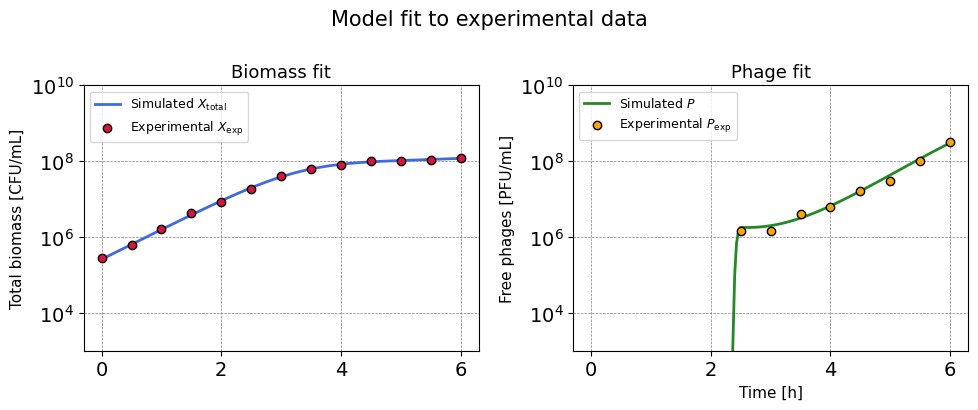

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', len(p_opt))  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

p_opt = DM(p_opt)
print(p_opt)
# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Extract simulated components ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Plot: Model Fit to Experimental Data ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4.2))

# Subplot 1: Total Biomass
axs[0].plot(t_sim, X_total_sim, label='Simulated $X_{\\mathrm{total}}$', color='royalblue', linewidth=2)
axs[0].scatter(t_exp, X_exp, label='Experimental $X_{\\mathrm{exp}}$', color='crimson', edgecolor='black', zorder=5)
axs[0].set_ylabel('Total biomass [CFU/mL]', fontsize=11)
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Biomass fit', fontsize=13)
axs[0].legend(fontsize=9, loc='upper left')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Subplot 2: Free Phages
axs[1].plot(t_sim, P_sim, label='Simulated $P$', color='forestgreen', linewidth=2)
axs[1].scatter(t_exp, P_exp, label='Experimental $P_{\\mathrm{exp}}$', color='orange', edgecolor='black', zorder=5)
axs[1].set_xlabel('Time [h]', fontsize=11)
axs[1].set_ylabel('Free phages [PFU/mL]', fontsize=11)
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].set_title('Phage fit', fontsize=13)
axs[1].legend(fontsize=9, loc='upper left')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Overall title and layout
fig.suptitle('Model fit to experimental data', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 1])  # Ajusta el espacio reservado al título
plt.show()

In [ ]:
import scipy.interpolate
interp1d = scipy.interpolate.interp1d

# === 9. COMPUTE RESIDUALS AND MODEL METRICS ===
# --- Interpolación de la simulación al tiempo experimental ---
interp_X = interp1d(t_sim, X_total_sim, kind='linear')
interp_P = interp1d(t_sim, P_sim, kind='linear')

X_model = interp_X(t_exp)
P_model = interp_P(t_exp)

Y_model = np.column_stack([X_model, P_model])
Y_data  = np.column_stack([X_exp, P_exp])

# --- Calcular residuos ---
residuals = Y_data - Y_model
residuals_flat = residuals.flatten()

p_opt = np.array(p_opt.full()).flatten()
# --- Número de parámetros y observaciones ---
m = len(p_opt)          # número de parámetros ajustados
N = Y_data.size         # número total de datos (t × variables)

# --- Suma de cuadrados de los residuos (SS) ---
SS = np.sum(residuals_flat**2)

# --- R² total ---
SS_tot = np.sum((Y_data - np.mean(Y_data, axis=0))**2)
R2_global = 1 - SS / SS_tot

# --- R² ajustado ---
k = m  # número de parámetros ajustados (puede ser < m si algunos están fijos)
R2_adj = 1 - (SS / (N - k)) / (SS_tot / (N - 1))

# --- AIC y AICc ---
AIC = N * np.log(SS / N) + 2 * (m + 1)
AICc = AIC + (2 * (m + 1) * (m + 2)) / (N - m - 2)

# --- BIC ---
BIC = N * np.log(SS / N) + (m + 1) * np.log(N)

# --- Mostrar resultados ---
print(f"\n--- Métricas de Evaluación del Modelo ---")
print(f"R² global: {R2_global:.4f}")
print(f"R² ajustado: {R2_adj:.4f}")
print(f"Suma de residuos (SS): {SS:.4f}")
print(f"AIC: {AIC:.2f}")
print(f"AICc: {AICc:.2f}")
print(f"BIC: {BIC:.2f}")


--- Métricas de Evaluación del Modelo ---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65



--- Métricas de Evaluación del Modelo 8p---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65

## Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
a       = MX.sym('a')
ki      = MX.sym('ki')
s       = MX.sym('s')
rr      = MX.sym('rr')
b       = MX.sym('b')
p_decay = MX.sym('p_decay')
p = vertcat(rn,K,a,ki,s,rr,b,p_decay)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

### Sensibilidad

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

NameError: name 'sensitivity_analysis' is not defined

In [ ]:
# Umbral de sensibilidad
threshold = 0.01

# Supongamos que ya tienes G_mean (n_states x n_par)
# Aquí se genera el vector de salida
insignificant_mask = np.all(np.abs(G) < threshold, axis=0)

# Mostrar resultado
for i, flag in enumerate(insignificant_mask):
    estado = "INSIGNIFICANTE" if flag else "significativo"
    print(f"Parámetro p{i+1}: {estado}")

# Mínimo valor de significancia por parámetro
max_significance = np.max(np.abs(G), axis=0)

print("\nValor maximo de significancia por parámetro:")
for i, val in enumerate(max_significance):
    print(f"p{i+1}: {val:.4e}")

# Resultado: vector booleano
print("\nVector insignificancia:", insignificant_mask)

Valor maximo de significancia por parámetro 8p: p1: 6.5939e-01
p2: 3.0744e-01
p3: 2.6285e-01
p4: 2.4237e-01
p5: 2.1307e-01
p6: 7.1101e-02
p7: 2.7045e-01
p8: 1.5376e-02

Valor maximo de significancia por parámetro -:

Valor maximo de significancia por parámetro - -:

Valor maximo de significancia por parámetro - - -:

### Correlacion

In [ ]:
C = identifiability(x,p,ode,x0,t_exp,param,solver,Cmax)

### Significancia

#### Varianzas

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp, X_exp, grado)
X_poly_fit = np.polyval(coef_poly, t_exp)

# R² y varianza biomasa
residuals_X = X_exp - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp - np.mean(X_exp))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X  = np.mean(w_X_t**2)  * var_X_tot
var_XI = np.mean(w_XI_t**2) * var_X_tot
var_XR = np.mean(w_XR_t**2) * var_X_tot


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp != 0
t_filtered = t_exp[mask]
P_filtered = P_exp[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot:.4e}")
print(f" - Varianza de X: {var_X:.4e}")
print(f" - Varianza de XI: {var_XI:.4e}")
print(f" - Varianza de XR: {var_XR:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P:.4e}")

#### Significancia

In [ ]:
sigma2_x = np.array([var_X, var_XI, var_XR, var_P, 1e-16])

sigma, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

t_value 8p:[37.20402564 19.54509895  5.64605915 10.09617886  2.88507448  1.5457707  3.14085012  0.36720913]

t_value -:

t_value - -:

t_value - - -:

In [ ]:
# --- Define the DAE system and integrator ---
dae = {'x': x, 'ode': ode, 'z': [], 'alg': [], 'p': p}

# Create integrator with configured solver and time points
simulation = integrator('ode_integration', solver, dae, 0, t_exp)

# Simulate using estimated parameters
result = simulation(x0=x0, p=param)

# Upper confidence bound (param + 0.1*sigma)
result_u = simulation(x0=x0, p=param + 0.1 * sigma)

# Lower confidence bound (param - 0.1*sigma)
result_l = simulation(x0=x0, p=param - 0.1 * sigma)

# --- Extract and convert CasADi results ---
X_raw   = result['xf'].full().T
X_u_raw = result_u['xf'].full().T
X_l_raw = result_l['xf'].full().T

# --- Convert to observable variables (total biomass, phages) ---
Y_sim   = observables(X_raw)
Y_u_sim = observables(X_u_raw)
Y_l_sim = observables(X_l_raw)

# --- Plot simulation vs experimental data with confidence intervals ---
plt.figure(figsize=(14, 5.5))

# Subplot 1: Total Biomass
plt.subplot(1, 2, 1)
plt.plot(t_exp, Y_sim[:, 0], color='black', label='Simulated $X_{\\mathrm{total}}$', linewidth=2)
plt.plot(t_exp, Y_u_sim[:, 0], '--', color='cornflowerblue', label='Upper bound')
plt.plot(t_exp, Y_l_sim[:, 0], '--', color='mediumseagreen', label='Lower bound')
plt.scatter(t_exp, X_exp, color='crimson', edgecolor='black', zorder=5, label='Experimental $X_{\\mathrm{exp}}$')
plt.xlabel('Time [h]')
plt.ylabel('Total biomass [CFU/mL]')
plt.yscale('log')
plt.ylim([1e5, 1e10])
plt.title('Biomass fit with confidence bounds')
plt.legend(fontsize=9)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Subplot 2: Free Phages
plt.subplot(1, 2, 2)
plt.plot(t_exp, Y_sim[:, 1], color='black', label='Simulated $P$', linewidth=2)
plt.plot(t_exp, Y_u_sim[:, 1], '--', color='cornflowerblue', label='Upper bound')
plt.plot(t_exp, Y_l_sim[:, 1], '--', color='mediumseagreen', label='Lower bound')
plt.scatter(t_exp, P_exp, color='orange', edgecolor='black', zorder=5, label='Experimental $P_{\\mathrm{exp}}$')
plt.xlabel('Time [h]')
plt.ylabel('Free phages [PFU/mL]')
plt.yscale('log')
plt.ylim([1e5, 1e10])
plt.title('Phage fit with confidence bounds')
plt.legend(fontsize=9)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


# Modelo -p_decay

In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = p[2]
    ki      = p[3]
    s       = p[4]
    rr      = p[5]
    b       = p[6]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

## Calibracion

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 7)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     a      ki     s    rr   b    p_decay
p_lb = np.array([0.1, 1e8,  1e-10, 1e-10, 0.6, 0.1, 20])
p_ub = np.array([2.0, 1e10, 1e-2,  1e-5,  5,  1,   200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp, x_exp, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1819158e+09 0.00e+00 5.04e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

p_opt -p_decay: [1.77619, 1.16129e+08, 0.00905365, 1.61681e-09, 2.77948, 0.582064, 23.1149]

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = x0
    x_values = [x0]

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for i in np.arange(n):
        sol = integrador(x0 = xk, p = p)
        xk = sol['xf'].full().flatten()
        x_values.append(xk)

    x_values = np.array(x_values)

    return t_values, x_values

[1.77619, 1.16129e+08, 0.00905365, 1.61681e-09, 2.77948, 0.582064, 23.1149]


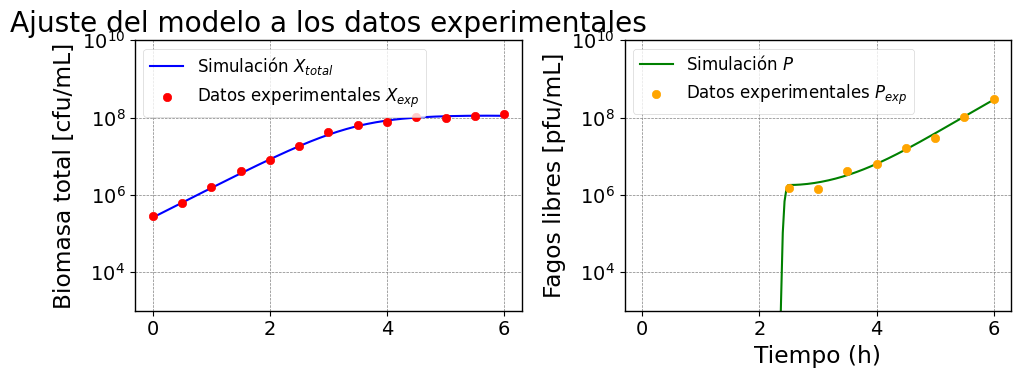

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 7)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

p_opt = DM(p_opt)
print(p_opt)
# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Recalcular componentes simuladas ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Crear figura con subplots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Biomasa total
axs[0].plot(t_sim, X_total_sim, label='Simulación $X_{total}$', color='blue')
axs[0].scatter(t_exp, X_exp, label='Datos experimentales $X_{exp}$', color='red', zorder=5)
axs[0].set_ylabel('Biomasa total [cfu/mL]')
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Ajuste del modelo a los datos experimentales')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Fagos libres
axs[1].plot(t_sim, P_sim, label='Simulación $P$', color='green')
axs[1].scatter(t_exp, P_exp, label='Datos experimentales $P_{exp}$', color='orange', zorder=5)
axs[1].set_xlabel('Tiempo (h)')
axs[1].set_ylabel('Fagos libres [pfu/mL]')
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import scipy.interpolate
interp1d = scipy.interpolate.interp1d

# === 9. COMPUTE RESIDUALS AND MODEL METRICS ===
# --- Interpolación de la simulación al tiempo experimental ---
interp_X = interp1d(t_sim, X_total_sim, kind='linear')
interp_P = interp1d(t_sim, P_sim, kind='linear')

X_model = interp_X(t_exp)
P_model = interp_P(t_exp)

Y_model = np.column_stack([X_model, P_model])
Y_data  = np.column_stack([X_exp, P_exp])

# --- Calcular residuos ---
residuals = Y_data - Y_model
residuals_flat = residuals.flatten()

p_opt = np.array(p_opt.full()).flatten()
# --- Número de parámetros y observaciones ---
m = len(p_opt)          # número de parámetros ajustados
N = Y_data.size         # número total de datos (t × variables)

# --- Suma de cuadrados de los residuos (SS) ---
SS = np.sum(residuals_flat**2)

# --- R² total ---
SS_tot = np.sum((Y_data - np.mean(Y_data, axis=0))**2)
R2_global = 1 - SS / SS_tot

# --- R² ajustado ---
k = m  # número de parámetros ajustados (puede ser < m si algunos están fijos)
R2_adj = 1 - (SS / (N - k)) / (SS_tot / (N - 1))

# --- AIC y AICc ---
AIC = N * np.log(SS / N) + 2 * (m + 1)
AICc = AIC + (2 * (m + 1) * (m + 2)) / (N - m - 2)

# --- BIC ---
BIC = N * np.log(SS / N) + (m + 1) * np.log(N)

# --- Mostrar resultados ---
print(f"\n--- Métricas de Evaluación del Modelo ---")
print(f"R² global: {R2_global:.4f}")
print(f"R² ajustado: {R2_adj:.4f}")
print(f"Suma de residuos (SS): {SS:.4f}")
print(f"AIC: {AIC:.2f}")
print(f"AICc: {AICc:.2f}")
print(f"BIC: {BIC:.2f}")


--- Métricas de Evaluación del Modelo ---
R² global: 0.9926
R² ajustado: 0.9903
Suma de residuos (SS): 877318613447690.6250
AIC: 825.89
AICc: 834.37
BIC: 835.96



--- Métricas de Evaluación del Modelo 8p---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65

--- Métricas de Evaluación del Modelo -p_decay---
R² global: 0.9926
R² ajustado: 0.9903
Suma de residuos (SS): 877318613447690.6250
AIC: 825.89
AICc: 834.37
BIC: 835.96

## Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
a       = MX.sym('a')
ki      = MX.sym('ki')
s       = MX.sym('s')
rr      = MX.sym('rr')
b       = MX.sym('b')
p = vertcat(rn,K,a,ki,s,rr,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

### Sensibilidad

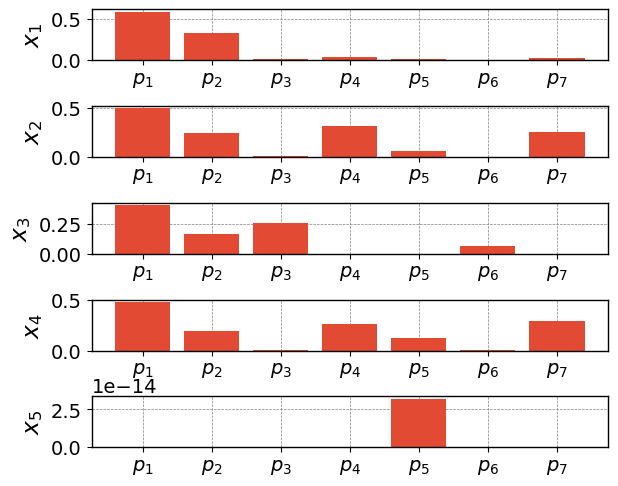

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

In [ ]:
# Umbral de sensibilidad
threshold = 0.01

# Supongamos que ya tienes G_mean (n_states x n_par)
# Aquí se genera el vector de salida
insignificant_mask = np.all(np.abs(G) < threshold, axis=0)

# Mostrar resultado
for i, flag in enumerate(insignificant_mask):
    estado = "INSIGNIFICANTE" if flag else "significativo"
    print(f"Parámetro p{i+1}: {estado}")

# Mínimo valor de significancia por parámetro
max_significance = np.max(np.abs(G), axis=0)

print("\nValor maximo de significancia por parámetro:")
for i, val in enumerate(max_significance):
    print(f"p{i+1}: {val:.4e}")

# Resultado: vector booleano
print("\nVector insignificancia:", insignificant_mask)

Parámetro p1: significativo
Parámetro p2: significativo
Parámetro p3: significativo
Parámetro p4: significativo
Parámetro p5: significativo
Parámetro p6: significativo
Parámetro p7: significativo

Valor maximo de significancia por parámetro:
p1: 5.8762e-01
p2: 3.2924e-01
p3: 2.5720e-01
p4: 3.1358e-01
p5: 1.2595e-01
p6: 6.9092e-02
p7: 2.8815e-01

Vector insignificancia: [False False False False False False False]


Valor maximo de significancia por parámetro 8p: p1: 6.5939e-01
p2: 3.0744e-01
p3: 2.6285e-01
p4: 2.4237e-01
p5: 2.1307e-01
p6: 7.1101e-02
p7: 2.7045e-01
p8: 1.5376e-02

Valor maximo de significancia por parámetro -p_decay: p1: 5.8762e-01
p2: 3.2924e-01
p3: 2.5720e-01
p4: 3.1358e-01
p5: 1.2595e-01
p6: 6.9092e-02
p7: 2.8815e-01

Valor maximo de significancia por parámetro - -:

Valor maximo de significancia por parámetro - - -:

### Correlacion

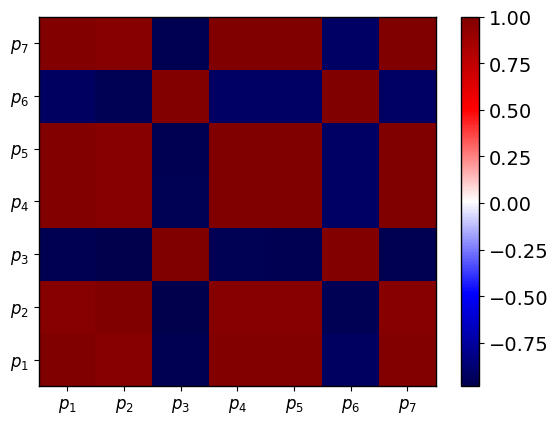

parameters with high correlation >= 0.95
1 and 2
1 and 3
1 and 4
1 and 5
1 and 7
2 and 1
2 and 3
2 and 4
2 and 5
2 and 6
2 and 7
3 and 1
3 and 2
3 and 4
3 and 5
3 and 6
3 and 7
4 and 1
4 and 2
4 and 3
4 and 5
4 and 7
5 and 1
5 and 2
5 and 3
5 and 4
5 and 7
6 and 2
6 and 3
7 and 1
7 and 2
7 and 3
7 and 4
7 and 5


In [ ]:
C = identifiability(x,p,ode,x0,t_exp,param,solver,Cmax)

### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp, X_exp, grado)
X_poly_fit = np.polyval(coef_poly, t_exp)

# R² y varianza biomasa
residuals_X = X_exp - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp - np.mean(X_exp))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X  = np.mean(w_X_t**2)  * var_X_tot
var_XI = np.mean(w_XI_t**2) * var_X_tot
var_XR = np.mean(w_XR_t**2) * var_X_tot


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp != 0
t_filtered = t_exp[mask]
P_filtered = P_exp[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot:.4e}")
print(f" - Varianza de X: {var_X:.4e}")
print(f" - Varianza de XI: {var_XI:.4e}")
print(f" - Varianza de XR: {var_XR:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9574
 - Varianza total: 9.5724e+13
 - Varianza de X: 7.5208e+13
 - Varianza de XI: 5.7174e+09
 - Varianza de XR: 7.7763e+09

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9994
 - Varianza de los residuos: 3.9374e+12


In [ ]:
sigma2_x = np.array([var_X, var_XI, var_XR, var_P, 1e-16])

sigma, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.77618805e+00 1.16129177e+08 9.05365286e-03 1.61680877e-09
 2.77948180e+00 5.82063829e-01 2.31149346e+01]

Desviación estándar (sigma): [3.77475157e-02 5.80258175e+06 1.31850336e-03 5.46440243e-10
 1.59657576e+00 3.38790699e-01 1.28207258e+01]

Valor t (t_value): [47.05443565 20.0133634   6.86661339  2.95880253  1.74090191  1.71806319
  1.80293495]

Intervalo de confianza inferior (CI_l): [ 1.70069302e+00  1.04524014e+08  6.41664613e-03  5.23928286e-10
 -4.13669729e-01 -9.55175689e-02 -2.52651691e+00]

Intervalo de confianza superior (CI_u): [1.85168308e+00 1.27734341e+08 1.16906596e-02 2.70968926e-09
 5.97263333e+00 1.25964523e+00 4.87563861e+01]


t_value 8p: [37.20402564 19.54509895  5.64605915 10.09617886  2.88507448  1.5457707  3.14085012  0.36720913]

t_value -p_decay: [47.05443565 20.0133634   6.86661339  2.95880253  1.74090191  1.71806319
  1.80293495]

t_value - -:

t_value - - -:

# Modelo -p_decay -rr


In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = p[2]
    ki      = p[3]
    s       = p[4]
    rr      = 0.582064
    b       = p[5]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

## Calibracion

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 6)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-4,
    'ipopt.acceptable_tol': 1e-4,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-4,
    'reltol': 1e-4,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     a      ki     s    b
p_lb = np.array([0.1, 1e8,  1e-10, 1e-10, 0.6, 20])
p_ub = np.array([2.0, 1e10, 1e-2,  1e-5,  5,   200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp, x_exp, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1786548e+09 0.00e+00 4.95e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

p_opt -p_decay: [1.77619, 1.16129e+08, 0.00905365, 1.61681e-09, 2.77948, 0.582064, 23.1149]

p_opt -p -rr: [1.82063, 1.06356e+08, 4.99642e-06, 5.99062e-09, 0.600012, 20.3955]

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = x0
    x_values = [x0]

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for i in np.arange(n):
        sol = integrador(x0 = xk, p = p)
        xk = sol['xf'].full().flatten()
        x_values.append(xk)

    x_values = np.array(x_values)

    return t_values, x_values

[1.82063, 1.06356e+08, 4.99642e-06, 5.99062e-09, 0.600012, 20.3955]


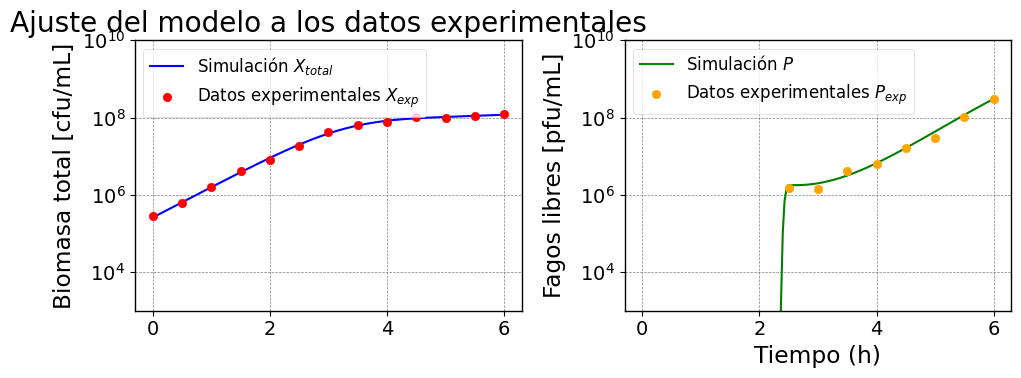

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 6)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

p_opt = DM(p_opt)
print(p_opt)
# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Recalcular componentes simuladas ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Crear figura con subplots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Biomasa total
axs[0].plot(t_sim, X_total_sim, label='Simulación $X_{total}$', color='blue')
axs[0].scatter(t_exp, X_exp, label='Datos experimentales $X_{exp}$', color='red', zorder=5)
axs[0].set_ylabel('Biomasa total [cfu/mL]')
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Ajuste del modelo a los datos experimentales')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Fagos libres
axs[1].plot(t_sim, P_sim, label='Simulación $P$', color='green')
axs[1].scatter(t_exp, P_exp, label='Datos experimentales $P_{exp}$', color='orange', zorder=5)
axs[1].set_xlabel('Tiempo (h)')
axs[1].set_ylabel('Fagos libres [pfu/mL]')
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import scipy.interpolate
interp1d = scipy.interpolate.interp1d

# === 9. COMPUTE RESIDUALS AND MODEL METRICS ===
# --- Interpolación de la simulación al tiempo experimental ---
interp_X = interp1d(t_sim, X_total_sim, kind='linear')
interp_P = interp1d(t_sim, P_sim, kind='linear')

X_model = interp_X(t_exp)
P_model = interp_P(t_exp)

Y_model = np.column_stack([X_model, P_model])
Y_data  = np.column_stack([X_exp, P_exp])

# --- Calcular residuos ---
residuals = Y_data - Y_model
residuals_flat = residuals.flatten()

p_opt = np.array(p_opt.full()).flatten()
# --- Número de parámetros y observaciones ---
m = len(p_opt)          # número de parámetros ajustados
N = Y_data.size         # número total de datos (t × variables)

# --- Suma de cuadrados de los residuos (SS) ---
SS = np.sum(residuals_flat**2)

# --- R² total ---
SS_tot = np.sum((Y_data - np.mean(Y_data, axis=0))**2)
R2_global = 1 - SS / SS_tot

# --- R² ajustado ---
k = m  # número de parámetros ajustados (puede ser < m si algunos están fijos)
R2_adj = 1 - (SS / (N - k)) / (SS_tot / (N - 1))

# --- AIC y AICc ---
AIC = N * np.log(SS / N) + 2 * (m + 1)
AICc = AIC + (2 * (m + 1) * (m + 2)) / (N - m - 2)

# --- BIC ---
BIC = N * np.log(SS / N) + (m + 1) * np.log(N)

# --- Mostrar resultados ---
print(f"\n--- Métricas de Evaluación del Modelo ---")
print(f"R² global: {R2_global:.4f}")
print(f"R² ajustado: {R2_adj:.4f}")
print(f"Suma de residuos (SS): {SS:.4f}")
print(f"AIC: {AIC:.2f}")
print(f"AICc: {AICc:.2f}")
print(f"BIC: {BIC:.2f}")


--- Métricas de Evaluación del Modelo ---
R² global: 0.9953
R² ajustado: 0.9941
Suma de residuos (SS): 558030293077052.0000
AIC: 812.13
AICc: 818.35
BIC: 820.94



--- Métricas de Evaluación del Modelo 8p---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65

--- Métricas de Evaluación del Modelo -p_decay---
R² global: 0.9926
R² ajustado: 0.9903
Suma de residuos (SS): 877318613447690.6250
AIC: 825.89
AICc: 834.37
BIC: 835.96

--- Métricas de Evaluación del Modelo -p -rr---
R² global: 0.9953
R² ajustado: 0.9941
Suma de residuos (SS): 558030293077052.0000
AIC: 812.13
AICc: 818.35
BIC: 820.94

## Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
a       = MX.sym('a')
ki      = MX.sym('ki')
s       = MX.sym('s')
b       = MX.sym('b')
p = vertcat(rn,K,a,ki,s,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

### Sensibilidad

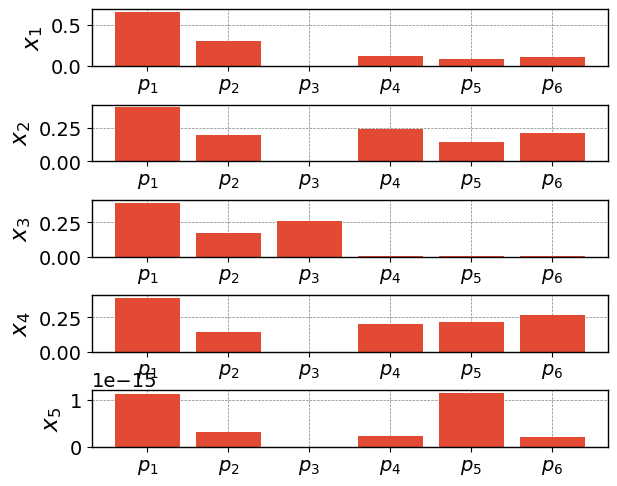

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

In [ ]:
# Umbral de sensibilidad
threshold = 0.01

# Supongamos que ya tienes G_mean (n_states x n_par)
# Aquí se genera el vector de salida
insignificant_mask = np.all(np.abs(G) < threshold, axis=0)

# Mostrar resultado
for i, flag in enumerate(insignificant_mask):
    estado = "INSIGNIFICANTE" if flag else "significativo"
    print(f"Parámetro p{i+1}: {estado}")

# Mínimo valor de significancia por parámetro
max_significance = np.max(np.abs(G), axis=0)

print("\nValor maximo de significancia por parámetro:")
for i, val in enumerate(max_significance):
    print(f"p{i+1}: {val:.4e}")

# Resultado: vector booleano
print("\nVector insignificancia:", insignificant_mask)

Parámetro p1: significativo
Parámetro p2: significativo
Parámetro p3: significativo
Parámetro p4: significativo
Parámetro p5: significativo
Parámetro p6: significativo

Valor maximo de significancia por parámetro:
p1: 6.6041e-01
p2: 3.0778e-01
p3: 2.6293e-01
p4: 2.4229e-01
p5: 2.1333e-01
p6: 2.7074e-01

Vector insignificancia: [False False False False False False]


Valor maximo de significancia por parámetro 8p: p1: 6.5939e-01
p2: 3.0744e-01
p3: 2.6285e-01
p4: 2.4237e-01
p5: 2.1307e-01
p6: 7.1101e-02
p7: 2.7045e-01
p8: 1.5376e-02

Valor maximo de significancia por parámetro -p_decay: p1: 5.8762e-01
p2: 3.2924e-01
p3: 2.5720e-01
p4: 3.1358e-01
p5: 1.2595e-01
p6: 6.9092e-02
p7: 2.8815e-01

Valor maximo de significancia por parámetro -p -rr: p1: 6.6041e-01
p2: 3.0778e-01
p3: 2.6293e-01
p4: 2.4229e-01
p5: 2.1333e-01
p6: 2.7074e-01

Valor maximo de significancia por parámetro - - -:

### Correlacion

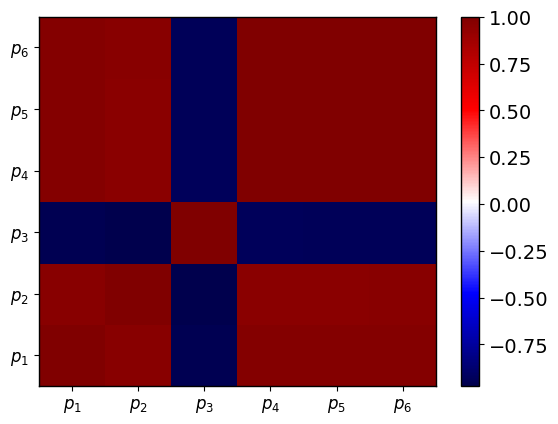

parameters with high correlation >= 0.95
1 and 2
1 and 3
1 and 4
1 and 5
1 and 6
2 and 1
2 and 3
2 and 4
2 and 5
2 and 6
3 and 1
3 and 2
4 and 1
4 and 2
4 and 5
4 and 6
5 and 1
5 and 2
5 and 4
5 and 6
6 and 1
6 and 2
6 and 4
6 and 5


In [ ]:
C = identifiability(x,p,ode,x0,t_exp,param,solver,Cmax)

### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp, X_exp, grado)
X_poly_fit = np.polyval(coef_poly, t_exp)

# R² y varianza biomasa
residuals_X = X_exp - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp - np.mean(X_exp))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X  = np.mean(w_X_t**2)  * var_X_tot
var_XI = np.mean(w_XI_t**2) * var_X_tot
var_XR = np.mean(w_XR_t**2) * var_X_tot


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp != 0
t_filtered = t_exp[mask]
P_filtered = P_exp[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot:.4e}")
print(f" - Varianza de X: {var_X:.4e}")
print(f" - Varianza de XI: {var_XI:.4e}")
print(f" - Varianza de XR: {var_XR:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9574
 - Varianza total: 9.5724e+13
 - Varianza de X: 7.3873e+13
 - Varianza de XI: 2.1066e+11
 - Varianza de XR: 2.3408e+03

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9994
 - Varianza de los residuos: 3.9374e+12


In [ ]:
sigma2_x = np.array([var_X, var_XI, var_XR, var_P, 1e-16])

sigma, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.82062947e+00 1.06355995e+08 4.99641548e-06 5.99062144e-09
 6.00012127e-01 2.03955488e+01]

Desviación estándar (sigma): [3.41124941e-02 5.15505220e+06 2.06657060e-07 4.87186686e-10
 1.92416588e-01 6.33133348e+00]

Valor t (t_value): [53.37133859 20.63140994 24.17732782 12.29635706  3.11829731  3.22136701]

Intervalo de confianza inferior (CI_l): [1.75240448e+00 9.60458909e+07 4.58310136e-06 5.01624807e-09
 2.15178952e-01 7.73288184e+00]

Intervalo de confianza superior (CI_u): [1.88885446e+00 1.16666100e+08 5.40972960e-06 6.96499481e-09
 9.84845303e-01 3.30582158e+01]


t_value 8p: [37.20402564 19.54509895  5.64605915 10.09617886  2.88507448  1.5457707  3.14085012  0.36720913]

t_value -p_decay: [47.05443565 20.0133634   6.86661339  2.95880253  1.74090191  1.71806319
  1.80293495]

t_value -p -rr: [9.25115812e+01 2.35529429e+01 3.01082149e-02 3.08667373e+01
 6.20083772e+00 6.52924066e+00]

t_value - - -:

# Modelo -p_decay -rr -a


In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = 4.99642e-06
    ki      = p[2]
    s       = p[3]
    rr      = 0.582064
    b       = p[4]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

## Calibracion

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 5)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     ki     s    b
p_lb = np.array([0.1, 1e8, 1e-10, 0.6, 20])
p_ub = np.array([2.0, 1e10,  1e-5,  5,   200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp, x_exp, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.2049450e+09 0.00e+00 5.22e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

p_opt -p_decay: [1.77619, 1.16129e+08, 0.00905365, 1.61681e-09, 2.77948, 0.582064, 23.1149]

p_opt -p -rr: [1.82063, 1.06356e+08, 4.99642e-06, 5.99062e-09, 0.600012, 20.3955]

p_opt -p -rr -a: [1.77024, 1.1562e+08, 1.5734e-09, 2.47758, 24.6669]

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = x0
    x_values = [x0]

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for i in np.arange(n):
        sol = integrador(x0 = xk, p = p)
        xk = sol['xf'].full().flatten()
        x_values.append(xk)

    x_values = np.array(x_values)

    return t_values, x_values

[1.77024, 1.1562e+08, 1.5734e-09, 2.47758, 24.6669]


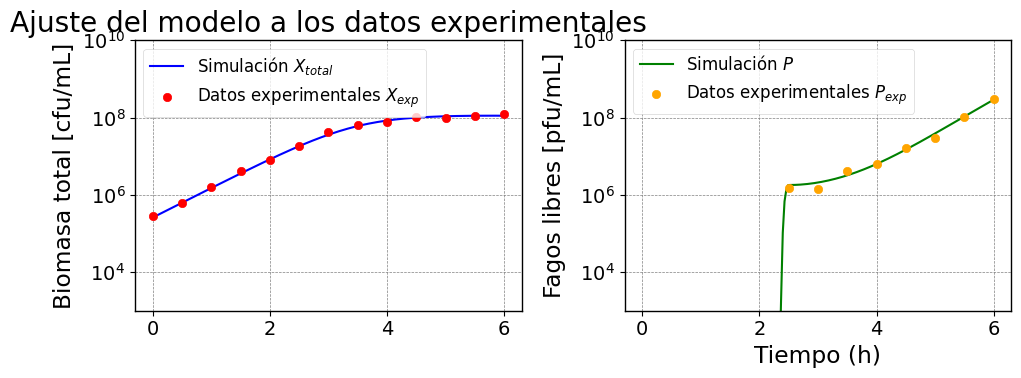

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 5)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

p_opt = DM(p_opt)
print(p_opt)
# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Recalcular componentes simuladas ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Crear figura con subplots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: Biomasa total
axs[0].plot(t_sim, X_total_sim, label='Simulación $X_{total}$', color='blue')
axs[0].scatter(t_exp, X_exp, label='Datos experimentales $X_{exp}$', color='red', zorder=5)
axs[0].set_ylabel('Biomasa total [cfu/mL]')
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Ajuste del modelo a los datos experimentales')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Fagos libres
axs[1].plot(t_sim, P_sim, label='Simulación $P$', color='green')
axs[1].scatter(t_exp, P_exp, label='Datos experimentales $P_{exp}$', color='orange', zorder=5)
axs[1].set_xlabel('Tiempo (h)')
axs[1].set_ylabel('Fagos libres [pfu/mL]')
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import scipy.interpolate
interp1d = scipy.interpolate.interp1d

# === 9. COMPUTE RESIDUALS AND MODEL METRICS ===
# --- Interpolación de la simulación al tiempo experimental ---
interp_X = interp1d(t_sim, X_total_sim, kind='linear')
interp_P = interp1d(t_sim, P_sim, kind='linear')

X_model = interp_X(t_exp)
P_model = interp_P(t_exp)

Y_model = np.column_stack([X_model, P_model])
Y_data  = np.column_stack([X_exp, P_exp])

# --- Calcular residuos ---
residuals = Y_data - Y_model
residuals_flat = residuals.flatten()

p_opt = np.array(p_opt.full()).flatten()
# --- Número de parámetros y observaciones ---
m = len(p_opt)          # número de parámetros ajustados
N = Y_data.size         # número total de datos (t × variables)

# --- Suma de cuadrados de los residuos (SS) ---
SS = np.sum(residuals_flat**2)

# --- R² total ---
SS_tot = np.sum((Y_data - np.mean(Y_data, axis=0))**2)
R2_global = 1 - SS / SS_tot

# --- R² ajustado ---
k = m  # número de parámetros ajustados (puede ser < m si algunos están fijos)
R2_adj = 1 - (SS / (N - k)) / (SS_tot / (N - 1))

# --- AIC y AICc ---
AIC = N * np.log(SS / N) + 2 * (m + 1)
AICc = AIC + (2 * (m + 1) * (m + 2)) / (N - m - 2)

# --- BIC ---
BIC = N * np.log(SS / N) + (m + 1) * np.log(N)

# --- Mostrar resultados ---
print(f"\n--- Métricas de Evaluación del Modelo ---")
print(f"R² global: {R2_global:.4f}")
print(f"R² ajustado: {R2_adj:.4f}")
print(f"Suma de residuos (SS): {SS:.4f}")
print(f"AIC: {AIC:.2f}")
print(f"AICc: {AICc:.2f}")
print(f"BIC: {BIC:.2f}")


--- Métricas de Evaluación del Modelo ---
R² global: 0.9934
R² ajustado: 0.9921
Suma de residuos (SS): 784197883182470.5000
AIC: 818.98
AICc: 823.40
BIC: 826.53



--- Métricas de Evaluación del Modelo 8p---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65

--- Métricas de Evaluación del Modelo -p_decay---
R² global: 0.9926
R² ajustado: 0.9903
Suma de residuos (SS): 877318613447690.6250
AIC: 825.89
AICc: 834.37
BIC: 835.96

--- Métricas de Evaluación del Modelo -p -rr---
R² global: 0.9953
R² ajustado: 0.9941
Suma de residuos (SS): 558030293077052.0000
AIC: 812.13
AICc: 818.35
BIC: 820.94

--- Métricas de Evaluación del Modelo -p -rr -a---
R² global: 0.9934
R² ajustado: 0.9921
Suma de residuos (SS): 784197883182470.5000
AIC: 818.98
AICc: 823.40
BIC: 826.53

## Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
ki      = MX.sym('ki')
s       = MX.sym('s')
b       = MX.sym('b')
p = vertcat(rn,K,ki,s,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

### Sensibilidad

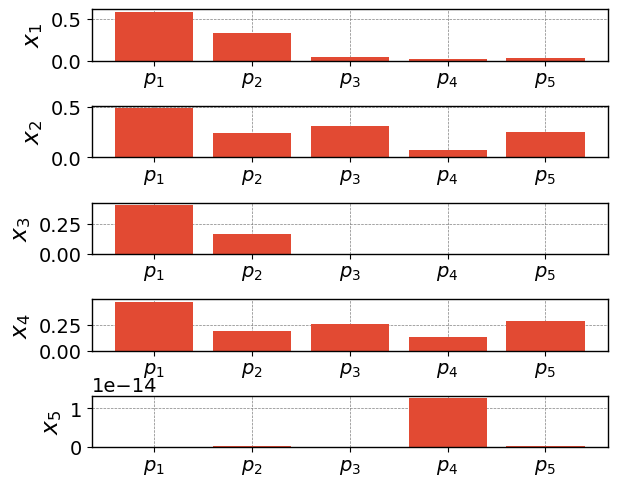

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

In [ ]:
# Umbral de sensibilidad
threshold = 0.01

# Supongamos que ya tienes G_mean (n_states x n_par)
# Aquí se genera el vector de salida
insignificant_mask = np.all(np.abs(G) < threshold, axis=0)

# Mostrar resultado
for i, flag in enumerate(insignificant_mask):
    estado = "INSIGNIFICANTE" if flag else "significativo"
    print(f"Parámetro p{i+1}: {estado}")

# Mínimo valor de significancia por parámetro
max_significance = np.max(np.abs(G), axis=0)

print("\nValor maximo de significancia por parámetro:")
for i, val in enumerate(max_significance):
    print(f"p{i+1}: {val:.4e}")

# Resultado: vector booleano
print("\nVector insignificancia:", insignificant_mask)

Parámetro p1: significativo
Parámetro p2: significativo
Parámetro p3: significativo
Parámetro p4: significativo
Parámetro p5: significativo

Valor maximo de significancia por parámetro:
p1: 5.8101e-01
p2: 3.2780e-01
p3: 3.0683e-01
p4: 1.3179e-01
p5: 2.8228e-01

Vector insignificancia: [False False False False False]


Valor maximo de significancia por parámetro 8p: p1: 6.5939e-01
p2: 3.0744e-01
p3: 2.6285e-01
p4: 2.4237e-01
p5: 2.1307e-01
p6: 7.1101e-02
p7: 2.7045e-01
p8: 1.5376e-02

Valor maximo de significancia por parámetro -p_decay: p1: 5.8762e-01
p2: 3.2924e-01
p3: 2.5720e-01
p4: 3.1358e-01
p5: 1.2595e-01
p6: 6.9092e-02
p7: 2.8815e-01

Valor maximo de significancia por parámetro -p -rr: p1: 6.6041e-01
p2: 3.0778e-01
p3: 2.6293e-01
p4: 2.4229e-01
p5: 2.1333e-01
p6: 2.7074e-01

Valor maximo de significancia por parámetro -p -rr -a: p1: 5.8101e-01
p2: 3.2780e-01
p3: 3.0683e-01
p4: 1.3179e-01
p5: 2.8228e-01

### Correlacion

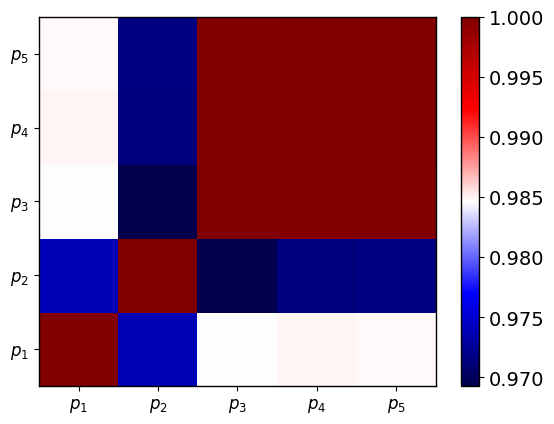

parameters with high correlation >= 0.95
1 and 2
1 and 3
1 and 4
1 and 5
2 and 1
2 and 3
2 and 4
2 and 5
3 and 1
3 and 2
3 and 4
3 and 5
4 and 1
4 and 2
4 and 3
4 and 5
5 and 1
5 and 2
5 and 3
5 and 4


In [ ]:
C = identifiability(x,p,ode,x0,t_exp,param,solver,Cmax)

### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp, X_exp, grado)
X_poly_fit = np.polyval(coef_poly, t_exp)

# R² y varianza biomasa
residuals_X = X_exp - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp - np.mean(X_exp))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X  = np.mean(w_X_t**2)  * var_X_tot
var_XI = np.mean(w_XI_t**2) * var_X_tot
var_XR = np.mean(w_XR_t**2) * var_X_tot


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp != 0
t_filtered = t_exp[mask]
P_filtered = P_exp[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot:.4e}")
print(f" - Varianza de X: {var_X:.4e}")
print(f" - Varianza de XI: {var_XI:.4e}")
print(f" - Varianza de XR: {var_XR:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9574
 - Varianza total: 9.5724e+13
 - Varianza de X: 7.6552e+13
 - Varianza de XI: 6.3861e+09
 - Varianza de XR: 2.4123e+03

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9994
 - Varianza de los residuos: 3.9374e+12


In [ ]:
sigma2_x = np.array([var_X, var_XI, var_XR, var_P, 1e-16])

sigma, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.77023809e+00 1.15620462e+08 1.57339776e-09 2.47757546e+00
 2.46669106e+01]

Desviación estándar (sigma): [3.06433990e-02 3.72766470e+06 4.71921935e-10 1.31176251e+00
 1.26653018e+01]

Valor t (t_value): [57.76898624 31.01686199  3.33402126  1.88873781  1.94759753]

Intervalo de confianza inferior (CI_l): [ 1.70895130e+00  1.08165132e+08  6.29553893e-10 -1.45949567e-01
 -6.63693118e-01]

Intervalo de confianza superior (CI_u): [1.83152489e+00 1.23075791e+08 2.51724163e-09 5.10110048e+00
 4.99975143e+01]


t_value 8p: [37.20402564 19.54509895  5.64605915 10.09617886  2.88507448  1.5457707  3.14085012  0.36720913]

t_value -p_decay: [47.05443565 20.0133634   6.86661339  2.95880253  1.74090191  1.71806319
  1.80293495]

t_value -p -rr: [9.25115812e+01 2.35529429e+01 3.01082149e-02 3.08667373e+01
 6.20083772e+00 6.52924066e+00]

t_value -p -rr -a: [57.76898624 31.01686199  3.33402126  1.88873781  1.94759753]

# Modelo -p_decay -rr -a -s


In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = 4.99642e-06
    ki      = p[2]
    s       = 2.47758
    rr      = 0.582064
    b       = p[3]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

## Calibracion

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 4)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     ki     b
p_lb = np.array([0.1, 1e8, 1e-10, 20])
p_ub = np.array([2.0, 1e10,  1e-5, 200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp, x_exp, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.1921488e+09 0.00e+00 5.23e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

p_opt -p_decay: [1.77619, 1.16129e+08, 0.00905365, 1.61681e-09, 2.77948, 0.582064, 23.1149]

p_opt -p -rr: [1.82063, 1.06356e+08, 4.99642e-06, 5.99062e-09, 0.600012, 20.3955]

p_opt -p -rr -a: [1.77024, 1.1562e+08, 1.5734e-09, 2.47758, 24.6669]

p_opt -p -rr -a -s: [1.77408, 1.14137e+08, 1.86483e-10, 194.213]

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = x0
    x_values = [x0]

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for i in np.arange(n):
        sol = integrador(x0 = xk, p = p)
        xk = sol['xf'].full().flatten()
        x_values.append(xk)

    x_values = np.array(x_values)

    return t_values, x_values

[1.77408, 1.14137e+08, 1.86483e-10, 194.213]


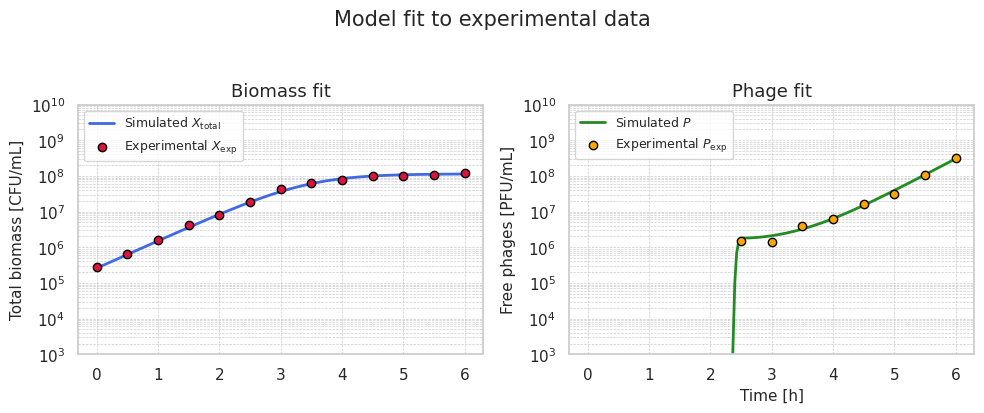

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 4)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

p_opt = DM(p_opt)
print(p_opt)
# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Extract simulated components ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Plot: Model Fit to Experimental Data ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4.2))

# Subplot 1: Total Biomass
axs[0].plot(t_sim, X_total_sim, label='Simulated $X_{\\mathrm{total}}$', color='royalblue', linewidth=2)
axs[0].scatter(t_exp, X_exp, label='Experimental $X_{\\mathrm{exp}}$', color='crimson', edgecolor='black', zorder=5)
axs[0].set_ylabel('Total biomass [CFU/mL]', fontsize=11)
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Biomass fit', fontsize=13)
axs[0].legend(fontsize=9, loc='upper left')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Subplot 2: Free Phages
axs[1].plot(t_sim, P_sim, label='Simulated $P$', color='forestgreen', linewidth=2)
axs[1].scatter(t_exp, P_exp, label='Experimental $P_{\\mathrm{exp}}$', color='orange', edgecolor='black', zorder=5)
axs[1].set_xlabel('Time [h]', fontsize=11)
axs[1].set_ylabel('Free phages [PFU/mL]', fontsize=11)
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].set_title('Phage fit', fontsize=13)
axs[1].legend(fontsize=9, loc='upper left')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Overall title and layout
fig.suptitle('Model fit to experimental data', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [ ]:
import scipy.interpolate
interp1d = scipy.interpolate.interp1d

# === 9. COMPUTE RESIDUALS AND MODEL METRICS ===
# --- Interpolación de la simulación al tiempo experimental ---
interp_X = interp1d(t_sim, X_total_sim, kind='linear')
interp_P = interp1d(t_sim, P_sim, kind='linear')

X_model = interp_X(t_exp)
P_model = interp_P(t_exp)

Y_model = np.column_stack([X_model, P_model])
Y_data  = np.column_stack([X_exp, P_exp])

# --- Calcular residuos ---
residuals = Y_data - Y_model
residuals_flat = residuals.flatten()

p_opt = np.array(p_opt.full()).flatten()
# --- Número de parámetros y observaciones ---
m = len(p_opt)          # número de parámetros ajustados
N = Y_data.size         # número total de datos (t × variables)

# --- Suma de cuadrados de los residuos (SS) ---
SS = np.sum(residuals_flat**2)

# --- R² total ---
SS_tot = np.sum((Y_data - np.mean(Y_data, axis=0))**2)
R2_global = 1 - SS / SS_tot

# --- R² ajustado ---
k = m  # número de parámetros ajustados (puede ser < m si algunos están fijos)
R2_adj = 1 - (SS / (N - k)) / (SS_tot / (N - 1))

# --- AIC y AICc ---
AIC = N * np.log(SS / N) + 2 * (m + 1)
AICc = AIC + (2 * (m + 1) * (m + 2)) / (N - m - 2)

# --- BIC ---
BIC = N * np.log(SS / N) + (m + 1) * np.log(N)

# --- Mostrar resultados ---
print(f"\n--- Métricas de Evaluación del Modelo ---")
print(f"R² global: {R2_global:.4f}")
print(f"R² ajustado: {R2_adj:.4f}")
print(f"Suma de residuos (SS): {SS:.4f}")
print(f"AIC: {AIC:.2f}")
print(f"AICc: {AICc:.2f}")
print(f"BIC: {BIC:.2f}")


--- Métricas de Evaluación del Modelo ---
R² global: 0.9962
R² ajustado: 0.9957
Suma de residuos (SS): 450912552785448.8125
AIC: 802.59
AICc: 805.59
BIC: 808.88



--- Métricas de Evaluación del Modelo 8p---
R² global: 0.9953
R² ajustado: 0.9934
Suma de residuos (SS): 562346959824707.5625
AIC: 816.33
AICc: 827.58
BIC: 827.65

--- Métricas de Evaluación del Modelo -p_decay---
R² global: 0.9926
R² ajustado: 0.9903
Suma de residuos (SS): 877318613447690.6250
AIC: 825.89
AICc: 834.37
BIC: 835.96

--- Métricas de Evaluación del Modelo -p -rr---
R² global: 0.9953
R² ajustado: 0.9941
Suma de residuos (SS): 558030293077052.0000
AIC: 812.13
AICc: 818.35
BIC: 820.94

--- Métricas de Evaluación del Modelo -p -rr -a---
R² global: 0.9934
R² ajustado: 0.9921
Suma de residuos (SS): 784197883182470.5000
AIC: 818.98
AICc: 823.40
BIC: 826.53

--- Métricas de Evaluación del Modelo -p -rr -a -s---
R² global: 0.9962
R² ajustado: 0.9957
Suma de residuos (SS): 450912552785448.8125
AIC: 802.59
AICc: 805.59
BIC: 808.88

## Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
ki      = MX.sym('ki')
b       = MX.sym('b')
p = vertcat(rn,K,ki,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

### Sensibilidad

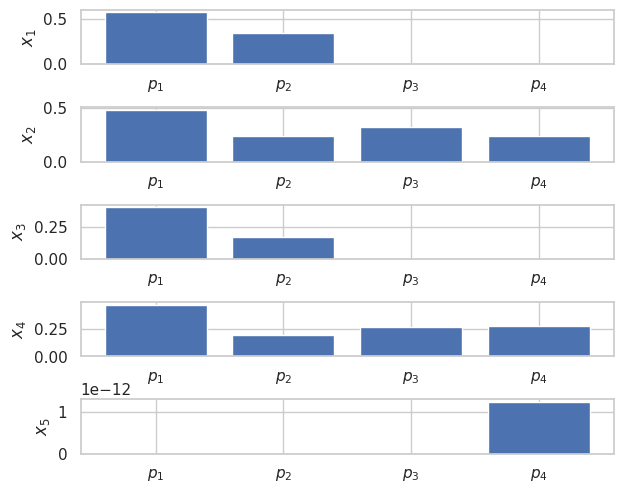

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

In [ ]:
# Umbral de sensibilidad
threshold = 0.01

# Supongamos que ya tienes G_mean (n_states x n_par)
# Aquí se genera el vector de salida
insignificant_mask = np.all(np.abs(G) < threshold, axis=0)

# Mostrar resultado
for i, flag in enumerate(insignificant_mask):
    estado = "INSIGNIFICANTE" if flag else "significativo"
    print(f"Parámetro p{i+1}: {estado}")

# Mínimo valor de significancia por parámetro
max_significance = np.max(np.abs(G), axis=0)

print("\nValor maximo de significancia por parámetro:")
for i, val in enumerate(max_significance):
    print(f"p{i+1}: {val:.4e}")

# Resultado: vector booleano
print("\nVector insignificancia:", insignificant_mask)

Parámetro p1: significativo
Parámetro p2: significativo
Parámetro p3: significativo
Parámetro p4: significativo

Valor maximo de significancia por parámetro:
p1: 5.6912e-01
p2: 3.4059e-01
p3: 3.1822e-01
p4: 2.7098e-01

Vector insignificancia: [False False False False]


Valor maximo de significancia por parámetro 8p: p1: 6.5939e-01
p2: 3.0744e-01
p3: 2.6285e-01
p4: 2.4237e-01
p5: 2.1307e-01
p6: 7.1101e-02
p7: 2.7045e-01
p8: 1.5376e-02

Valor maximo de significancia por parámetro -p_decay: p1: 5.8762e-01
p2: 3.2924e-01
p3: 2.5720e-01
p4: 3.1358e-01
p5: 1.2595e-01
p6: 6.9092e-02
p7: 2.8815e-01

Valor maximo de significancia por parámetro -p -rr: p1: 6.6041e-01
p2: 3.0778e-01
p3: 2.6293e-01
p4: 2.4229e-01
p5: 2.1333e-01
p6: 2.7074e-01

Valor maximo de significancia por parámetro -p -rr -a: p1: 5.8101e-01
p2: 3.2780e-01
p3: 3.0683e-01
p4: 1.3179e-01
p5: 2.8228e-01

Valor maximo de significancia por parámetro -p -rr -a -s: p1: 5.6912e-01
p2: 3.4059e-01
p3: 3.1822e-01
p4: 2.7098e-01

### Correlacion

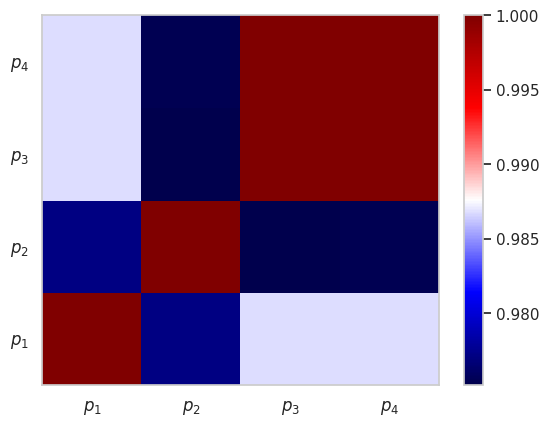

parameters with high correlation >= 0.95
1 and 2
1 and 3
1 and 4
2 and 1
2 and 3
2 and 4
3 and 1
3 and 2
3 and 4
4 and 1
4 and 2
4 and 3


In [ ]:
C = identifiability(x,p,ode,x0,t_exp,param,solver,Cmax)

### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp, X_exp, grado)
X_poly_fit = np.polyval(coef_poly, t_exp)

# R² y varianza biomasa
residuals_X = X_exp - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp - np.mean(X_exp))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X  = np.mean(w_X_t**2)  * var_X_tot
var_XI = np.mean(w_XI_t**2) * var_X_tot
var_XR = np.mean(w_XR_t**2) * var_X_tot


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp != 0
t_filtered = t_exp[mask]
P_filtered = P_exp[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot:.4e}")
print(f" - Varianza de X: {var_X:.4e}")
print(f" - Varianza de XI: {var_XI:.4e}")
print(f" - Varianza de XR: {var_XR:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9574
 - Varianza total: 9.5724e+13
 - Varianza de X: 7.6858e+13
 - Varianza de XI: 9.5276e+07
 - Varianza de XR: 2.4010e+03

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9994
 - Varianza de los residuos: 3.9374e+12


In [ ]:
sigma2_x = np.array([var_X, var_XI, var_XR, var_P, 1e-16])

sigma, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.77408328e+00 1.14136692e+08 1.86482818e-10 1.94213396e+02]

Desviación estándar (sigma): [1.57262494e-02 2.36838390e+06 3.74951966e-12 2.56252109e+00]

Valor t (t_value): [112.81032384  48.19180372  49.73512211  75.78996998]

Intervalo de confianza inferior (CI_l): [1.74263078e+00 1.09399924e+08 1.78983779e-10 1.89088354e+02]

Intervalo de confianza superior (CI_u): [1.80553578e+00 1.18873460e+08 1.93981858e-10 1.99338438e+02]


t_value 8p: [37.20402564 19.54509895  5.64605915 10.09617886  2.88507448  1.5457707  3.14085012  0.36720913]

t_value -p_decay: [47.05443565 20.0133634   6.86661339  2.95880253  1.74090191  1.71806319  1.80293495]

t_value -p -rr: [9.25115812e+01 2.35529429e+01 3.01082149e-02 3.08667373e+01
 6.20083772e+00 6.52924066e+00]

t_value -p -rr -a: [57.76898624 31.01686199  3.33402126  1.88873781  1.94759753]

t_value -p -rr -a -s: [86.8645768  43.24408086  3.21152437  3.25305397]

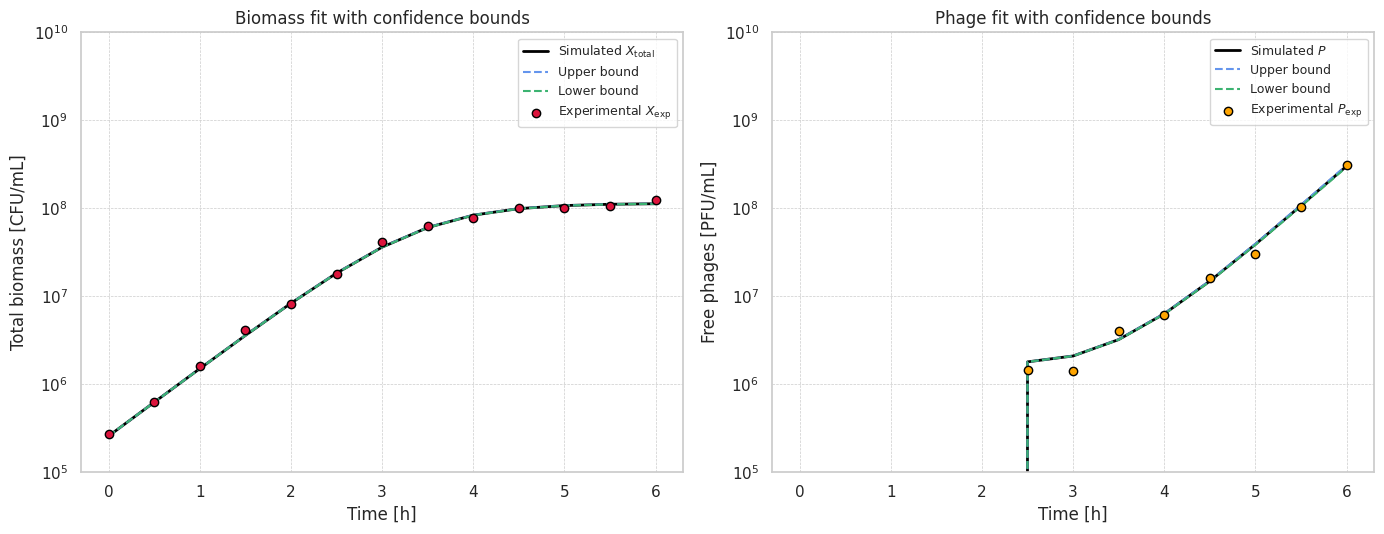

In [ ]:
# --- Define the DAE system and integrator ---
dae = {'x': x, 'ode': ode, 'z': [], 'alg': [], 'p': p}

# Create integrator with configured solver and time points
simulation = integrator('ode_integration', solver, dae, 0, t_exp)

# Simulate using estimated parameters
result = simulation(x0=x0, p=param)

# Upper confidence bound (param + 0.1*sigma)
result_u = simulation(x0=x0, p=param + 0.1 * sigma)

# Lower confidence bound (param - 0.1*sigma)
result_l = simulation(x0=x0, p=param - 0.1 * sigma)

# --- Extract and convert CasADi results ---
X_raw   = result['xf'].full().T
X_u_raw = result_u['xf'].full().T
X_l_raw = result_l['xf'].full().T

# --- Convert to observable variables (total biomass, phages) ---
Y_sim   = observables(X_raw)
Y_u_sim = observables(X_u_raw)
Y_l_sim = observables(X_l_raw)

# --- Plot simulation vs experimental data with confidence intervals ---
plt.figure(figsize=(14, 5.5))

# Subplot 1: Total Biomass
plt.subplot(1, 2, 1)
plt.plot(t_exp, Y_sim[:, 0], color='black', label='Simulated $X_{\\mathrm{total}}$', linewidth=2)
plt.plot(t_exp, Y_u_sim[:, 0], '--', color='cornflowerblue', label='Upper bound')
plt.plot(t_exp, Y_l_sim[:, 0], '--', color='mediumseagreen', label='Lower bound')
plt.scatter(t_exp, X_exp, color='crimson', edgecolor='black', zorder=5, label='Experimental $X_{\\mathrm{exp}}$')
plt.xlabel('Time [h]')
plt.ylabel('Total biomass [CFU/mL]')
plt.yscale('log')
plt.ylim([1e5, 1e10])
plt.title('Biomass fit with confidence bounds')
plt.legend(fontsize=9)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Subplot 2: Free Phages
plt.subplot(1, 2, 2)
plt.plot(t_exp, Y_sim[:, 1], color='black', label='Simulated $P$', linewidth=2)
plt.plot(t_exp, Y_u_sim[:, 1], '--', color='cornflowerblue', label='Upper bound')
plt.plot(t_exp, Y_l_sim[:, 1], '--', color='mediumseagreen', label='Lower bound')
plt.scatter(t_exp, P_exp, color='orange', edgecolor='black', zorder=5, label='Experimental $P_{\\mathrm{exp}}$')
plt.xlabel('Time [h]')
plt.ylabel('Free phages [PFU/mL]')
plt.yscale('log')
plt.ylim([1e5, 1e10])
plt.title('Phage fit with confidence bounds')
plt.legend(fontsize=9)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Frecuencia de muestreo

## Modelo 15min

In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = 4.99642e-06
    ki      = p[2]
    s       = 2.47758
    rr      = 0.582064
    b       = p[3]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

### Calibracion

In [ ]:
# === 6. LOAD EXPERIMENTAL DATA ===
data15  = pd.read_excel('Datos_modelo_15min.xlsx')
t_exp15 = data15.iloc[:,0].to_numpy()
X_exp15 = data15.iloc[:,1].to_numpy()
P_exp15 = data15.iloc[:,2].to_numpy()

x_exp15 = np.column_stack([X_exp15, P_exp15])

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 4)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     ki     b
p_lb = np.array([0.1, 1e8, 1e-10, 20])
p_ub = np.array([2.0, 1e10,  1e-5, 200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp15, x_exp15, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0302300e+10 0.00e+00 1.22e+05  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = DM(x0)  # Convierte x0_val (numpy) en CasADi.DM
    x_values = [xk]  # Primera entrada ya como DM

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for _ in range(n):
        sol = integrador(x0=xk, p=DM(p))
        xk = sol['xf']
        x_values.append(xk)

    # Convierte todos los valores a np.array
    x_values = np.array([x.full().flatten() for x in x_values])

    return t_values, x_values

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 4)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp15[0], tf=t_exp15[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Extract simulated components ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

### Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
ki      = MX.sym('ki')
b       = MX.sym('b')
p = vertcat(rn,K,ki,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

#### Sensibilidad

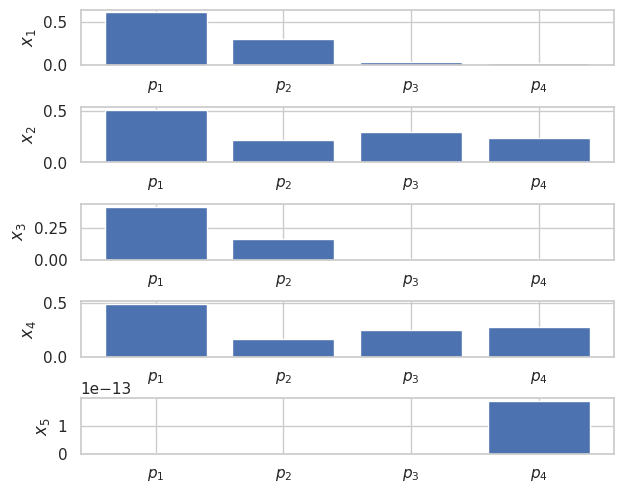

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp15,param,solver,stype)

#### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp15, X_exp15, grado)
X_poly_fit = np.polyval(coef_poly, t_exp15)

# R² y varianza biomasa
residuals_X = X_exp15 - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp15 - np.mean(X_exp15))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot15 = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X15  = np.mean(w_X_t**2)  * var_X_tot15
var_XI15 = np.mean(w_XI_t**2) * var_X_tot15
var_XR15 = np.mean(w_XR_t**2) * var_X_tot15


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp15 != 0
t_filtered = t_exp15[mask]
P_filtered = P_exp15[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P15 = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot15:.4e}")
print(f" - Varianza de X: {var_X15:.4e}")
print(f" - Varianza de XI: {var_XI15:.4e}")
print(f" - Varianza de XR: {var_XR15:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P15:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9433
 - Varianza total: 1.1200e+14
 - Varianza de X: 9.0418e+13
 - Varianza de XI: 8.4865e+09
 - Varianza de XR: 2.9342e+03

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9430
 - Varianza de los residuos: 2.0126e+14


In [ ]:
sigma2_x15 = np.array([var_X15, var_XI15, var_XR15, var_P15, 1e-16])
sigma15, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp15,param,'cvodes',sigma2_x15)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.69544031e+00 1.14375220e+08 1.87165643e-09 2.15271746e+01]

Desviación estándar (sigma): [1.57262494e-02 2.36838390e+06 3.74951966e-12 2.56252109e+00]

Valor t (t_value): [98.62872385 46.66995086 23.70589374 21.8245745 ]

Intervalo de confianza inferior (CI_l): [1.66106006e+00 1.09473770e+08 1.71375001e-09 1.95544283e+01]

Intervalo de confianza superior (CI_u): [1.72982057e+00 1.19276671e+08 2.02956285e-09 2.34999209e+01]


t_value 30min: [86.8645768  43.24408086  3.21152437  3.25305397]

t_value 15min: [98.62872385 46.66995086 23.70589374 21.8245745 ]

## Modelo 10min

In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
def phage_bacteria(x, p):
    # --- Estados ---
    X   = x[0]   # Bacterias sensibles
    XI  = x[1]   # Bacterias infectadas
    XR  = x[2]   # Bacterias resistentes
    P   = x[3]   # Fagos libres
    t   = x[4]   # Tiempo (estado auxiliar)

    # --- Parámetros del modelo ---
    rn      = p[0]
    K       = p[1]
    a       = 4.99642e-06
    ki      = p[2]
    s       = 2.47758
    rr      = 0.582064
    b       = p[3]
    p_decay = 0.0996885

    # --- Parámetros del pulso (fijos) ---
    inyeccion= 1.81e6
    t_inf    = 2.4
    delta_t  = 0.08
    P0       = inyeccion/delta_t
    k        = 150

    # --- Pulso tipo sigmoide ---
    pulse = P0 * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))

    X_safe = fmax(X, 1e-8)
    P_safe = fmax(P, 1e-8)
    # --- Ecuaciones diferenciales ---
    dX_dt  = rn * X_safe * (1 - (X_safe + XR)/K) - a * X_safe - ki * X_safe * P_safe
    dXI_dt = ki * X_safe * P_safe - s * XI
    dXR_dt = rr * XR * (1 - (X_safe + XR)/K) + a * X_safe
    dP_dt  = b * s * XI - p_decay * P_safe - ki * X_safe * P_safe + pulse
    dt_dt  = 1.0

    # --- Salidas: derivadas + biomasa total como última componente ---
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

### Calibracion

In [ ]:
# === 6. LOAD EXPERIMENTAL DATA ===
data10  = pd.read_excel('Datos_modelo_10min.xlsx')
t_exp10 = data10.iloc[:,0].to_numpy()
X_exp10 = data10.iloc[:,1].to_numpy()
P_exp10 = data10.iloc[:,2].to_numpy()

x_exp10 = np.column_stack([X_exp10, P_exp10])

In [ ]:
# === 7. DEFINE SYMBOLIC VARIABLES AND BOUNDS ===
# Define symbolic state variables and parameters
x = MX.sym('x', 5)
p = MX.sym('p', 4)

# Define method and options for the optimizer and integrator
opt_solver = 'ipopt'
solver_opts = {
    'ipopt.tol': 1e-3,
    'ipopt.acceptable_tol': 1e-3,
    'ipopt.max_iter': 700,
    'ipopt.print_level': 5
}
int_solver = 'idas'
int_opts = {
    'abstol': 1e-3,
    'reltol': 1e-3,
    'max_num_steps': 1e12
}

# Define initial conditions and create init_cond dictionary
#                rn   K     ki     b
p_lb = np.array([0.1, 1e8, 1e-10, 20])
p_ub = np.array([2.0, 1e10,  1e-5, 200])
p_init = (p_lb + p_ub) / 2
x0_val = np.array([2.58e5, 0, 0, 0, 0]) # Condiciones iniciales del IVP
init_cond = {'p0': p_init, 'p_lb': p_lb, 'p_ub': p_ub, 'x0': x0_val}

# Optimize
p_opt = fit_model(phage_bacteria, x, p, t_exp10, x_exp10, init_cond,
                          int_solver, int_opts, opt_solver, solver_opts)
print('\np_opt', p_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5106589e+10 0.00e+00 7.25e+04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

p_opt 30min:  [1.77408, 1.14137e+08, 1.86483e-10, 194.213]

p_opt 15min: [1.69544031e+00 1.14375220e+08 1.87165643e-09 2.15271746e+01]

p_opt 10min: [1.71735471e+00 1.15493485e+08 1.99262026e-10 2.00000001e+02]

In [ ]:
def simulation(ti, tf, n, x0, p, dae):
    xk = DM(x0)  # Convierte x0_val (numpy) en CasADi.DM
    x_values = [xk]  # Primera entrada ya como DM

    h_ = (tf - ti) / n
    t_values = np.linspace(ti, tf, n+1)

    int_opts = {'tf': h_}
    integrador = integrator('F', 'cvodes', dae, int_opts)

    for _ in range(n):
        sol = integrador(x0=xk, p=DM(p))
        xk = sol['xf']
        x_values.append(xk)

    # Convierte todos los valores a np.array
    x_values = np.array([x.full().flatten() for x in x_values])

    return t_values, x_values

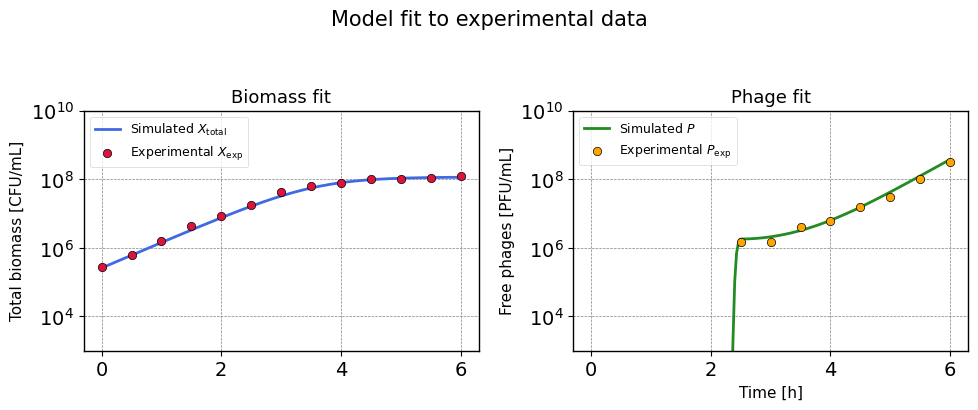

In [ ]:
# === 8. SIMULATE MODEL WITH OPTIMIZED PARAMETERS ===
# --- Estados y parámetros simbólicos ---
x = MX.sym('x', 5)  # o el tamaño real de tu sistema
p = MX.sym('p', 4)  # usa el largo correcto si es variable

# --- Definir modelo como función CasADi ---
model = Function('model', [x, p], [phage_bacteria(x, p)])
dae = {'x': x, 'p': p, 'ode': model(x, p)}

# --- Simular ---
t_sim, x_sim = simulation(ti=t_exp[0], tf=t_exp10[-1], n=200, x0=x0_val, p=p_opt, dae=dae)

# --- Extract simulated components ---
X_total_sim = x_sim[:, 0] + x_sim[:, 1] + x_sim[:, 2]
P_sim       = x_sim[:, 3]

# --- Plot: Model Fit to Experimental Data ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4.2))

# Subplot 1: Total Biomass
axs[0].plot(t_sim, X_total_sim, label='Simulated $X_{\\mathrm{total}}$', color='royalblue', linewidth=2)
axs[0].scatter(t_exp, X_exp, label='Experimental $X_{\\mathrm{exp}}$', color='crimson', edgecolor='black', zorder=5)
axs[0].set_ylabel('Total biomass [CFU/mL]', fontsize=11)
axs[0].set_yscale('log')
axs[0].set_ylim([1e3, 1e10])
axs[0].set_title('Biomass fit', fontsize=13)
axs[0].legend(fontsize=9, loc='upper left')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Subplot 2: Free Phages
axs[1].plot(t_sim, P_sim, label='Simulated $P$', color='forestgreen', linewidth=2)
axs[1].scatter(t_exp, P_exp, label='Experimental $P_{\\mathrm{exp}}$', color='orange', edgecolor='black', zorder=5)
axs[1].set_xlabel('Time [h]', fontsize=11)
axs[1].set_ylabel('Free phages [PFU/mL]', fontsize=11)
axs[1].set_yscale('log')
axs[1].set_ylim([1e3, 1e10])
axs[1].set_title('Phage fit', fontsize=13)
axs[1].legend(fontsize=9, loc='upper left')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Overall title and layout
fig.suptitle('Model fit to experimental data', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### Analisis de sensibilidad

In [ ]:
def observables(x_array):
    """
    Transforma los estados simulados en variables observables:
    biomasa total (X + XI + XR) y concentración de fagos (P).
    """
    biomasa_total = x_array[:, 0] + x_array[:, 1] + x_array[:, 2]
    fagos = x_array[:, 3]
    return np.column_stack([biomasa_total, fagos])

# %% declaration of variable (Casadi symbolic)
X = MX.sym('X')
XI = MX.sym('XI')
XR = MX.sym('XR')
P = MX.sym('P')
t = MX.sym('t')
x = vertcat(X, XI, XR, P, t)
rn      = MX.sym('rn')
K       = MX.sym('K')
ki      = MX.sym('ki')
b       = MX.sym('b')
p = vertcat(rn,K,ki,b)
ode = phage_bacteria(x,p)

x0      = [2.58e5, 0, 0, 0, 0] # initial condition
param   = p_opt
solver  = 'cvodes' # solver of integration
stype   = 'abs'  # type of sensitivity
Cmax    = 0.95   # threshold correlation coefficient

#### Sensibilidad

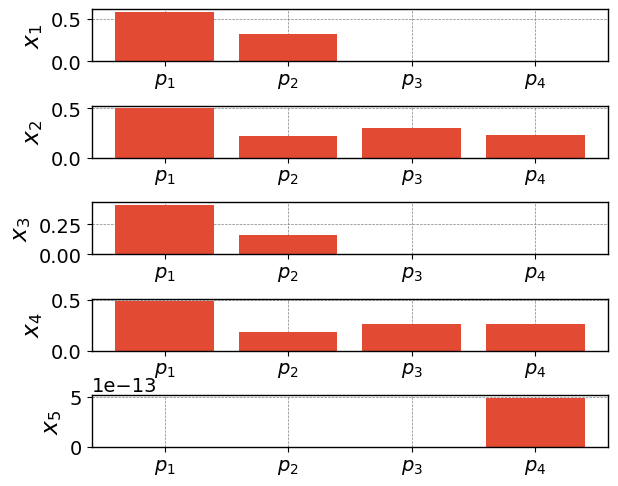

In [ ]:
stype = 'mean'
G, xstate = sensitivity_analysis(x,p,ode,x0,t_exp,param,solver,stype)

#### Significancia

In [ ]:
# === AJUSTE POLINOMIAL PARA X (BIOMASA) ===
grado = 2
coef_poly = np.polyfit(t_exp10, X_exp10, grado)
X_poly_fit = np.polyval(coef_poly, t_exp10)

# R² y varianza biomasa
residuals_X = X_exp10 - X_poly_fit
ss_res_X = np.sum(residuals_X**2)
ss_tot_X = np.sum((X_exp10 - np.mean(X_exp10))**2)
r2_X = 1 - ss_res_X / ss_tot_X
var_X_tot10 = np.var(residuals_X, ddof=1)

#repartición de varianzas
w_X_t  = x_sim[:, 0] / np.sum(x_sim, axis=1)
w_XI_t = x_sim[:, 1] / np.sum(x_sim, axis=1)
w_XR_t = x_sim[:, 2] / np.sum(x_sim, axis=1)

# --- Calcular varianzas empíricas de medición ---
var_X10  = np.mean(w_X_t**2)  * var_X_tot10
var_XI10 = np.mean(w_XI_t**2) * var_X_tot10
var_XR10 = np.mean(w_XR_t**2) * var_X_tot10


# === AJUSTE EXPONENCIAL PARA P (FAGOS ≠ 0) ===
def exp_func(t, a, b):
    return a * np.exp(b * t)

mask = P_exp10 != 0
t_filtered = t_exp10[mask]
P_filtered = P_exp10[mask]
params_P, _ = curve_fit(exp_func, t_filtered, P_filtered, p0=(1, 0.1))
P_fit = exp_func(t_filtered, *params_P)

# R² y varianza fagos
residuals_P = P_filtered - P_fit
ss_res_P = np.sum(residuals_P**2)
ss_tot_P = np.sum((P_filtered - np.mean(P_filtered))**2)
r2_P = 1 - ss_res_P / ss_tot_P
var_P10 = np.var(residuals_P, ddof=1)

# === RESULTADOS ===
print(f"Ajuste BIOMASA (X):")
print(f" - R²: {r2_X:.4f}")
print(f" - Varianza total: {var_X_tot10:.4e}")
print(f" - Varianza de X: {var_X10:.4e}")
print(f" - Varianza de XI: {var_XI10:.4e}")
print(f" - Varianza de XR: {var_XR10:.4e}")
print()
print(f"Ajuste FAGOS (P ≠ 0):")
print(f" - R²: {r2_P:.4f}")
print(f" - Varianza de los residuos: {var_P10:.4e}")

Ajuste BIOMASA (X):
 - R²: 0.9480
 - Varianza total: 1.0687e+14
 - Varianza de X: 8.4763e+13
 - Varianza de XI: 1.2886e+08
 - Varianza de XR: 2.5319e+03

Ajuste FAGOS (P ≠ 0):
 - R²: 0.9859
 - Varianza de los residuos: 9.3197e+13


In [ ]:
sigma2_x10 = np.array([var_X10, var_XI10, var_XR10, var_P10, 1e-16])

sigma10, t_value, CI_l, CI_u=significance(x,p,ode,x0,t_exp,param,solver,sigma2_x)

# Print de los parámetros estimados y los resultados del análisis de significancia
print("Resultados del análisis de significancia:")
print(f"\nParámetros estimados: {param}")
print(f"\nDesviación estándar (sigma): {sigma}")
print(f"\nValor t (t_value): {t_value}")
print(f"\nIntervalo de confianza inferior (CI_l): {CI_l}")
print(f"\nIntervalo de confianza superior (CI_u): {CI_u}")

Resultados del análisis de significancia:

Parámetros estimados: [1.71735471e+00 1.15493485e+08 1.99262026e-10 2.00000001e+02]

Desviación estándar (sigma): [2.04235529e-02 2.63935988e+06 5.80667611e-11 5.97018672e+01]

Valor t (t_value): [102.02480987  44.69300597   4.08322253   4.14237015]

Intervalo de confianza inferior (CI_l): [1.68368927e+00 1.10325183e+08 1.01661651e-10 1.03436926e+02]

Intervalo de confianza superior (CI_u): [1.75102014e+00 1.20661788e+08 2.96862402e-10 2.96563077e+02]


t_value 30min: [86.8645768  43.24408086  3.21152437  3.25305397]

t_value 15min: [98.62872385 46.66995086 23.70589374 21.8245745 ]

t_value 10min: [102.02480987  44.69300597   4.08322253   4.14237015]

# Optimización

In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
# ----------------------------- PARÁMETROS BASE -----------------------------

# Parámetros fijos
a       = 4.99642e-06
s       = 2.47758
rr      = 0.582064
p_decay = 0.0996885

p_opt = [1.69544031e+00, 1.14375220e+08, 1.87165643e-09, 2.15271746e+01]

# Combinar parámetros optimizados y fijos
fixed_params = np.array([p_opt[0], p_opt[1], a, p_opt[2], s, rr, p_opt[3], p_decay])

# ----------------------------- MODELO -----------------------------
def sigma_fn(z):
    return if_else(z >= 0, 1 / (1 + exp(-z)), exp(z) / (1 + exp(z)))

def phage_bacteria(x, p):
    X, XI, XR, P, t = vertsplit(x)
    rn, K, a, ki, s, rr, b, p_decay, inyeccion, t_inf = vertsplit(p)
    delta_t, k = 0.05, 200
    P0 = inyeccion / delta_t
    pulse = P0 * (sigma_fn(k*(t - t_inf)) - sigma_fn(k*(t - (t_inf + delta_t))))
    dX_dt  = rn * X * (1 - (X + XR) / K) - a * X - ki * X * P
    dXI_dt = ki * X * P - s * XI
    dXR_dt = rr * XR * (1 - (X + XR) / K) + a * X
    dP_dt  = b * s * XI - p_decay * P - ki * X * P + pulse
    dt_dt  = 1.0
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

# ----------------------------- SIMULADOR -----------------------------
x_sym = MX.sym('x', 5)
p_sym = MX.sym('p', 10)
dae = {'x': x_sym, 'p': p_sym, 'ode': phage_bacteria(x_sym, p_sym)}

t_final, n_steps = 6.0, 200
t_vals = np.linspace(0, t_final, n_steps)
dt = t_vals[1] - t_vals[0]

sim_step = integrator('sim', 'cvodes', dae, {'tf': dt, 'abstol':1e-8, 'reltol':1e-6, 'max_num_steps':5e5})

def run_fixed_simulation(params, x0=None):
    if x0 is None:
        x0 = np.array([2.58e5, 0, 0, 0, 0], float)
    sol = np.zeros((n_steps, 5))
    sol[0] = x0
    x_now = x0.copy()
    for i in range(1, n_steps):
        res = sim_step(x0=x_now, p=params)
        x_now = res['xf'].full().ravel()
        sol[i] = x_now
    return sol

# ----------------------------- FUNCIÓN OBJETIVO -----------------------------
def make_objective(fixed_params):
    def obj(vec):
        log_inj, t_inf = vec
        inj = 10 ** log_inj
        p_full = np.concatenate([fixed_params, [inj, t_inf]])
        sol = run_fixed_simulation(p_full)
        return -sol[:, 3].max()  # minimizar negativo de P_max
    return obj

obj_fn = make_objective(fixed_params)

import time

# Medir tiempo de inicio
start_time = time.time()

# Optimización de inyección
bounds = FloatVar(lb=[3, 0.1], ub=[7, 6.0])
problem = {"obj_func": obj_fn, "bounds": bounds, "minmax": "min"}
model = GWO.OriginalGWO(epoch=100, pop_size=30, verbose=False)
best = model.solve(problem)

end_time = time.time()
elapsed_time = end_time - start_time

# Obtener estrategia óptima
log_inj_opt, t_inf_opt = best.solution
P0_opt = 10 ** log_inj_opt

print(f"P0_opt: {P0_opt}")
print(f"t_inf_opt: {t_inf_opt}")
print(f"Tiempo de ejecución: {elapsed_time} segundos")

INFO:mealpy.swarm_based.GWO.OriginalGWO:OriginalGWO(epoch=100, pop_size=30)
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 1, Current best: -155267412.3233006, Global best: -155267412.3233006, Runtime: 3.46509 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 2, Current best: -155267412.3233006, Global best: -155267412.3233006, Runtime: 3.70177 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 3, Current best: -155270341.7589179, Global best: -155270341.7589179, Runtime: 3.00671 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 4, Current best: -155270341.7589179, Global best: -155270341.7589179, Runtime: 1.59756 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 5, Current best: -155270341.7589179, Global best: -155270341.7589179, Runtime: 1.63825 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 6, Current best: -155270341.7589179, Global best: -155270341.7589179, Runtime

P0_opt: 1000000.0
t_inf_opt: 1.3924083929656774
Tiempo de ejecución: 186.32493805885315 segundos


In [ ]:
print(f"P0_opt: {P0_opt}")
print(f"t_inf_opt: {t_inf_opt}")
print(f"Tiempo de ejecución: {elapsed_time} segundos")

P0_opt: 10000000.0
t_inf_opt: 1.5130036927334525
Tiempo de ejecución: 259.9690725803375 segundos


/tmp/ipython-input-9-3771868573.py:64: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-k * (t_grid - t_inf))) -
/tmp/ipython-input-9-3771868573.py:65: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-k * (t_grid - (t_inf + delta_t))))


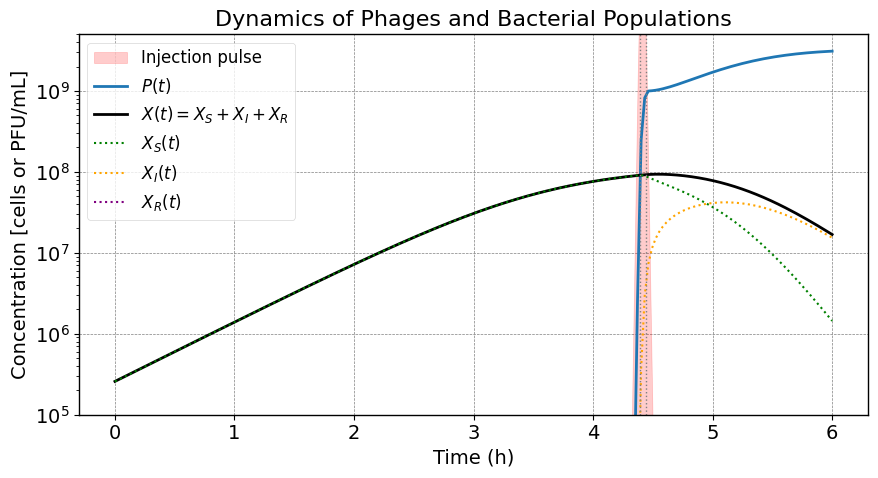

In [ ]:
# === 4. DEFINE PHAGE-BACTERIA MODEL ===
# ----------------------------- PARÁMETROS BASE -----------------------------

# Parámetros fijos
a       = 4.99642e-06
s       = 2.47758
rr      = 0.582064
p_decay = 0.0996885

p_opt = [1.69544031e+00, 1.14375220e+08, 1.87165643e-09, 2.15271746e+01]

# Combinar parámetros optimizados y fijos
fixed_params = np.array([p_opt[0], p_opt[1], a, p_opt[2], s, rr, p_opt[3], p_decay])

# --- Parámetros conocidos ---
t_inf = 1.52
delta_t = 0.05
k = 200
P0_opt = 1e7
P0_rate = P0_opt / delta_t

# ----------------------------- MODELO -----------------------------
def sigma_fn(z):
    return if_else(z >= 0, 1 / (1 + exp(-z)), exp(z) / (1 + exp(z)))

def phage_bacteria(x, p):
    X, XI, XR, P, t = vertsplit(x)
    rn, K, a, ki, s, rr, b, p_decay = vertsplit(p)
    delta_t, k = 0.05, 200
    pulse = P0_rate * (sigma_fn(k*(t - t_inf)) - sigma_fn(k*(t - (t_inf + delta_t))))
    dX_dt  = rn * X * (1 - (X + XR) / K) - a * X - ki * X * P
    dXI_dt = ki * X * P - s * XI
    dXR_dt = rr * XR * (1 - (X + XR) / K) + a * X
    dP_dt  = b * s * XI - p_decay * P - ki * X * P + pulse
    dt_dt  = 1.0
    return vertcat(dX_dt, dXI_dt, dXR_dt, dP_dt, dt_dt)

# ----------------------------- SIMULADOR -----------------------------
x_sym = MX.sym('x', 5)
p_sym = MX.sym('p', 8)
dae = {'x': x_sym, 'p': p_sym, 'ode': phage_bacteria(x_sym, p_sym)}

t_final, n_steps = 6.0, 200
t_vals = np.linspace(0, t_final, n_steps)
dt = t_vals[1] - t_vals[0]

sim_step = integrator('sim', 'cvodes', dae, {'tf': dt, 'abstol':1e-8, 'reltol':1e-6, 'max_num_steps':5e5})

def run_fixed_simulation(params, x0=None):
    if x0 is None:
        x0 = np.array([2.58e5, 0, 0, 0, 0], float)
    sol = np.zeros((n_steps, 5))
    sol[0] = x0
    x_now = x0.copy()
    for i in range(1, n_steps):
        res = sim_step(x0=x_now, p=params)
        x_now = res['xf'].full().ravel()
        sol[i] = x_now
    return sol

# --- Crear malla para pulso ---
t_grid = np.linspace(0, 6.0, 500)
pulse_vals = P0_rate * (
    1 / (1 + np.exp(-k * (t_grid - t_inf))) -
    1 / (1 + np.exp(-k * (t_grid - (t_inf + delta_t))))
)

# --- Simulación previa (ejemplo: ya ejecutaste run_fixed_simulation) ---
# Supongamos que tienes esto:
sol_24 = run_fixed_simulation(fixed_params)
t_vals_24 = np.linspace(0, 6.0, len(sol_24))

# --- Extraer variables de simulación ---
XS_vals   = sol_24[:, 0]
XI_vals  = sol_24[:, 1]
XR_vals  = sol_24[:, 2]
P_vals   = sol_24[:, 3]
X_vals   = XS_vals + XI_vals + XR_vals  # biomasa total

# === Gráfico con un solo eje ===
fig, ax = plt.subplots(figsize=(9, 5))

# Pulso como fondo
ax.fill_between(t_grid, pulse_vals, color='red', alpha=0.2, label='Injection pulse')

# Fagos
ax.plot(t_vals_24, P_vals, color='tab:blue', linewidth=2, label=r'$P(t)$')

# Bacterias
ax.plot(t_vals_24, X_vals, color='black', linewidth=2, label=r'$X(t) = X_S + X_I + X_R$')  # total
ax.plot(t_vals_24, XS_vals, color='green', linestyle=':', linewidth=1.5, label=r'$X_S(t)$')
ax.plot(t_vals_24, XI_vals, color='orange', linestyle=':', linewidth=1.5, label=r'$X_I(t)$')
ax.plot(t_vals_24, XR_vals, color='purple', linestyle=':', linewidth=1.5, label=r'$X_R(t)$')


# Estética log-log
ax.set_xlabel('Time (h)', fontsize=14)  # tamaño del título del eje X
ax.set_ylabel('Concentration [cells or PFU/mL]', fontsize=14)  # título del eje Y más grande
ax.set_yscale('log')
ax.set_ylim(1e5, 5e9)  # Ajusta si es necesario

# Líneas verticales del pulso
ax.axvline(x=t_inf, color='gray', linestyle=':', linewidth=1)
ax.axvline(x=t_inf + delta_t, color='gray', linestyle=':', linewidth=1)

# Leyenda y título
ax.legend(fontsize=12)
ax.set_title("Dynamics of Phages and Bacterial Populations", fontsize=16)

plt.tight_layout()
plt.show()

# Monte Carlo

In [ ]:
# Crear lista para guardar resultados
results_1 = []
opt_values = []
N_ITER = 500  # número de iteraciones

a       = 4.99642e-06
s       = 2.47758
rr      = 0.582064
p_decay = 0.0996885

p_opt = [1.69544031e+00, 1.14375220e+08, 1.87165643e-09, 2.15271746e+01]

P0_opt= 10000000.0
t_inf_opt: 1.5130036927334525
# ----------------------------- FUNCIÓN: MUESTRA PARÁMETROS -----------------------------
def generar_parametros_aleatorios():
    sampled = np.random.normal(p_opt, sigma15)
    return np.array([sampled[0], sampled[1], a, sampled[2], s, rr, sampled[3], p_decay])

def run_fixed_simulation(params, x0=None):
    if x0 is None:
        x0 = np.array([2.58e5, 0, 0, 0, 0], float)
    sol = np.zeros((n_steps, 5))
    sol[0] = x0
    x_now = x0.copy()
    for i in range(1, n_steps):
        res = sim_step(x0=x_now, p=params)
        x_now = res['xf'].full().ravel()
        sol[i] = x_now
    return sol

start_time = time.time()
for i in range(N_ITER):
    sampled = np.random.normal(p_opt, sigma15)

    # Extraer los 5 parámetros significativos
    rn, K, ki, b = sampled[0], sampled[1], sampled[2], sampled[3],

    # Construir vector completo de parámetros para el modelo (longitud 10)
    p_full = np.array([rn, K, a, ki, s, rr, b, p_decay, P0_opt, t_inf_opt])

    # Simulación
    sol = run_fixed_simulation(p_full)
    results_1.append(sol[:, 3].max())  # Guardar P_max

end_time = time.time()
elapsed_time = end_time - start_time

df_results = pd.DataFrame({"P_max": results_1})

# Guardar en archivo Excel
df_results.to_excel("montecarlo_fijo.xlsx", index=False)
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Tiempo de ejecución: 42.92358899116516 segundos


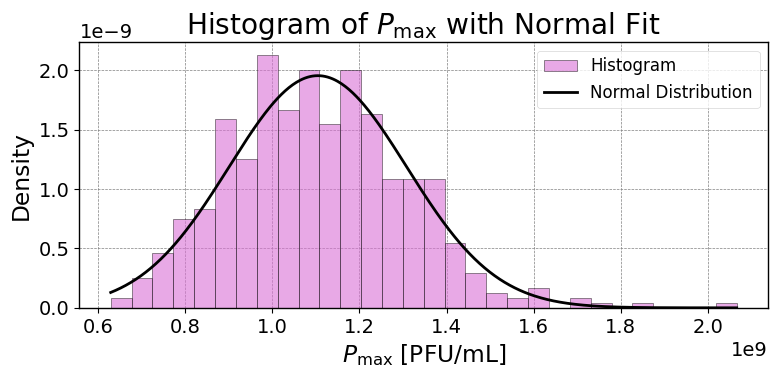

In [ ]:
mu = np.mean(results_1)
sig = np.std(results_1)

# Histograma + curva normal
plt.figure(figsize=(8, 4))
count, bins, _ = plt.hist(results_1, bins=30, density=True,
                          color='orchid', edgecolor='black', alpha=0.6, label="Histogram")

x_vals = np.linspace(min(results_1), max(results_1), 500)
pdf_vals = norm.pdf(x_vals, mu, sig)
plt.plot(x_vals, pdf_vals, color='black', linewidth=2, label="Normal Distribution")

plt.title("Histogram of $P_{\\mathrm{max}}$ with Normal Fit")
plt.xlabel("$P_{\\mathrm{max}}$ [PFU/mL]")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

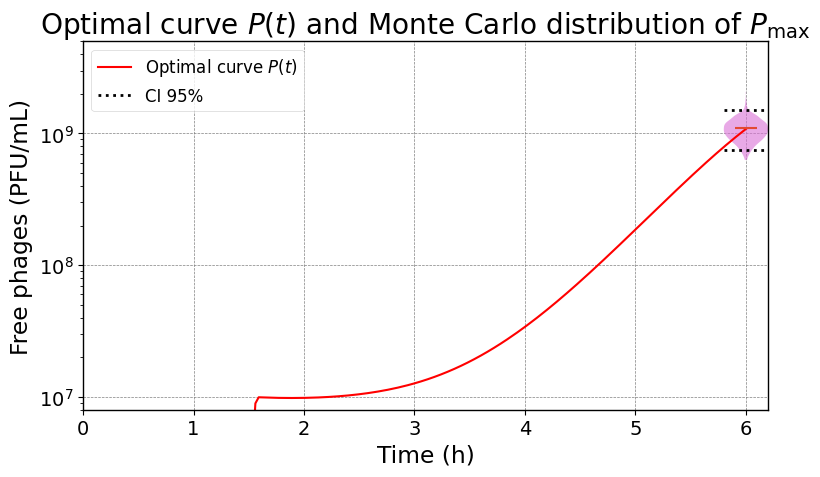

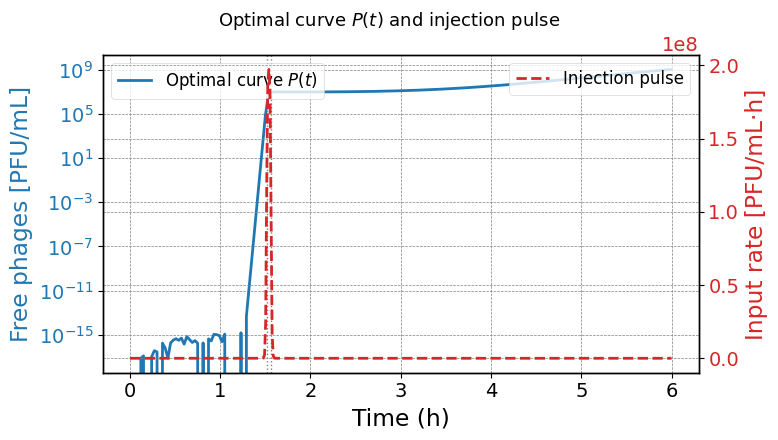

In [ ]:
delta_t = 0.05
k = 200
P0_rate = P0_opt / delta_t

# --- Modelo ---
def modelo_optimo(P0_rate, t_inf):
    x = MX.sym('x', 5)
    t = x[4]
    rn, K, a, ki, s, rr, b, p_decay = fixed_params

    pulse = P0_rate * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))
    X, XI, XR, P = x[0], x[1], x[2], x[3]
    dX  = rn * X * (1 - (X + XR)/K) - a * X - ki * X * P
    dXI = ki * X * P - s * XI
    dXR = rr * XR * (1 - (X + XR)/K) + a * X
    dP  = b * s * XI - p_decay * P - ki * X * P + pulse
    dt  = 1.0
    dxdt = vertcat(dX, dXI, dXR, dP, dt)
    return integrator('sim', 'cvodes', {'x': x, 'ode': dxdt}, {'tf': 0.03})

# --- Simulación ---
sim = modelo_optimo(P0_rate, t_inf_opt)
x0 = [2.58e5, 0, 0, 0, 0]
sol = [x0]
for _ in range(200):
    res = sim(x0=sol[-1])
    sol.append(res["xf"].full().flatten())
sol = np.array(sol)
t_vals_1 = sol[:, 4]
P_vals_1 = sol[:, 3]


p2p5 = np.percentile(results_1, 2.5)
p97 = np.percentile(results_1, 97.5)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 5))

# Curva óptima
ax.plot(t_vals_1, P_vals_1, color='red', label='Optimal curve $P(t)$')

# Violín
vp = ax.violinplot(results_1, positions=[6], widths=0.4,
                   showmeans=False, showmedians=True, showextrema=False)
for body in vp['bodies']:
    body.set_facecolor('orchid')
    body.set_alpha(0.6)

# Líneas IC del 95%
ax.hlines([p2p5, p97], xmin=5.8, xmax=6.2, colors='black', linestyles='dotted', linewidth=2, label='CI 95%')

# Formato
ax.set_xlim(0, 6.2)
ax.set_ylim(8e6, 5e9)
ax.set_yscale('log')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Free phages (PFU/mL)')
ax.set_title('Optimal curve $P(t)$ and Monte Carlo distribution of $P_{\\mathrm{max}}$')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# --- Término de pulso (evaluado en una malla densa) ---
t_grid = np.linspace(0, 6.0, 500)
pulse_vals = P0_rate * (
    1 / (1 + np.exp(-k * (t_grid - t_inf_opt))) -
    1 / (1 + np.exp(-k * (t_grid - (t_inf_opt + delta_t))))
)

### P0 y t_inf originales

In [ ]:
# Crear lista para guardar resultados
results_2 = []
opt_values = []
N_ITER = 500  # número de iteraciones

# ----------------------------- FUNCIÓN: MUESTRA PARÁMETROS -----------------------------
def generar_parametros_aleatorios():
    sampled = np.random.normal(p_opt, sigma15)
    return np.array([sampled[0], sampled[1], a, sampled[2], s, rr, sampled[3], p_decay])

for i in range(N_ITER):
    sampled = np.random.normal(p_opt, sigma15)

    # Extraer los 5 parámetros significativos
    rn, K, ki, b = sampled[0], sampled[1], sampled[2], sampled[3],

    # Construir vector completo de parámetros para el modelo (longitud 10)
    p_full = np.array([rn, K, a, ki, s, rr, b, p_decay, 1.81e6, 2.4])

    # Simulación
    sol = run_fixed_simulation(p_full)
    results_2.append(sol[:, 3].max())  # Guardar P_max

df_results_2 = pd.DataFrame({"P_max": results_2})

# Guardar en archivo Excel
df_results_2.to_excel("montecarlo_fijo_ori.xlsx", index=False)

In [ ]:
def imprimir_estadisticas(nombre, resultados):
    media = np.mean(resultados)
    desv  = np.std(resultados)
    p2p5  = np.percentile(resultados, 2.5)
    p97   = np.percentile(resultados, 97.5)

    print(f"--- {nombre} ---")
    print(f"Media (μ):           {media:,.2f}")
    print(f"Desviación estándar: {desv:,.2f}")
    print(f"IC 95%:              [{p2p5:,.2f}, {p97:,.2f}]\n")

# Mostrar resultados para ambas simulaciones
imprimir_estadisticas("Simulación con P0 optimizado", results_1)
imprimir_estadisticas("Simulación con P0 fijo (1.81e6)", results_2)

--- Simulación con P0 optimizado ---
Media (μ):           1,104,514,163.43
Desviación estándar: 204,033,070.71
IC 95%:              [754,237,243.07, 1,501,278,964.78]

--- Simulación con P0 fijo (1.81e6) ---
Media (μ):           242,597,951.80
Desviación estándar: 62,021,631.09
IC 95%:              [144,739,248.51, 378,613,221.08]



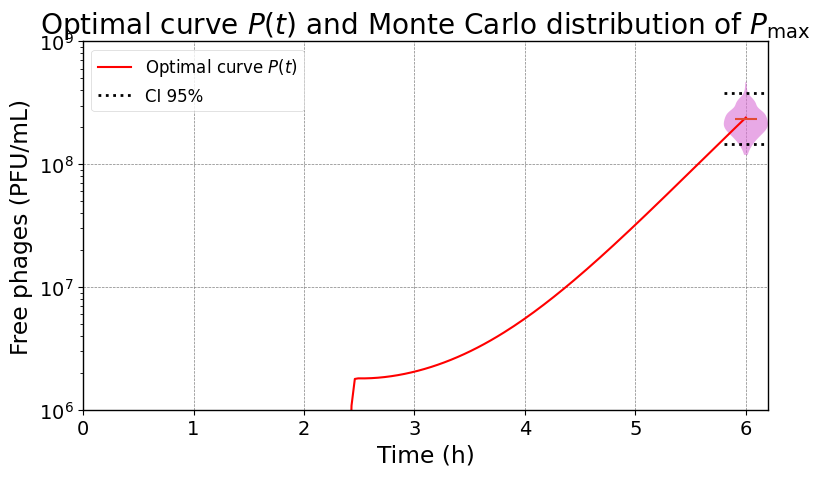

In [ ]:
delta_t = 0.05
k = 200
P0_rate = 1.81e6 / delta_t

# --- Modelo ---
def modelo_optimo(P0_rate, t_inf):
    x = MX.sym('x', 5)
    t = x[4]
    rn, K, a, ki, s, rr, b, p_decay = fixed_params

    pulse = P0_rate * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))
    X, XI, XR, P = x[0], x[1], x[2], x[3]
    dX  = rn * X * (1 - (X + XR)/K) - a * X - ki * X * P
    dXI = ki * X * P - s * XI
    dXR = rr * XR * (1 - (X + XR)/K) + a * X
    dP  = b * s * XI - p_decay * P - ki * X * P + pulse
    dt  = 1.0
    dxdt = vertcat(dX, dXI, dXR, dP, dt)
    return integrator('sim', 'cvodes', {'x': x, 'ode': dxdt}, {'tf': 0.03})

# --- Simulación ---
sim = modelo_optimo(P0_rate, 2.4)
x0 = [2.58e5, 0, 0, 0, 0]
sol = [x0]
for _ in range(200):
    res = sim(x0=sol[-1])
    sol.append(res["xf"].full().flatten())
sol = np.array(sol)
t_vals_2 = sol[:, 4]
P_vals_2 = sol[:, 3]


p2p5 = np.percentile(results_2, 2.5)
p97 = np.percentile(results_2, 97.5)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 5))

# Curva óptima
ax.plot(t_vals_2, P_vals_2, color='red', label='Optimal curve $P(t)$')

# Violín
vp = ax.violinplot(results_2, positions=[6], widths=0.4,
                   showmeans=False, showmedians=True, showextrema=False)
for body in vp['bodies']:
    body.set_facecolor('orchid')
    body.set_alpha(0.6)

# Líneas IC del 95%
ax.hlines([p2p5, p97], xmin=5.8, xmax=6.2, colors='black', linestyles='dotted', linewidth=2, label='CI 95%')

# Formato
ax.set_xlim(0, 6.2)
ax.set_ylim(1e6, 1e9)
ax.set_yscale('log')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Free phages (PFU/mL)')
ax.set_title('Optimal curve $P(t)$ and Monte Carlo distribution of $P_{\\mathrm{max}}$')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

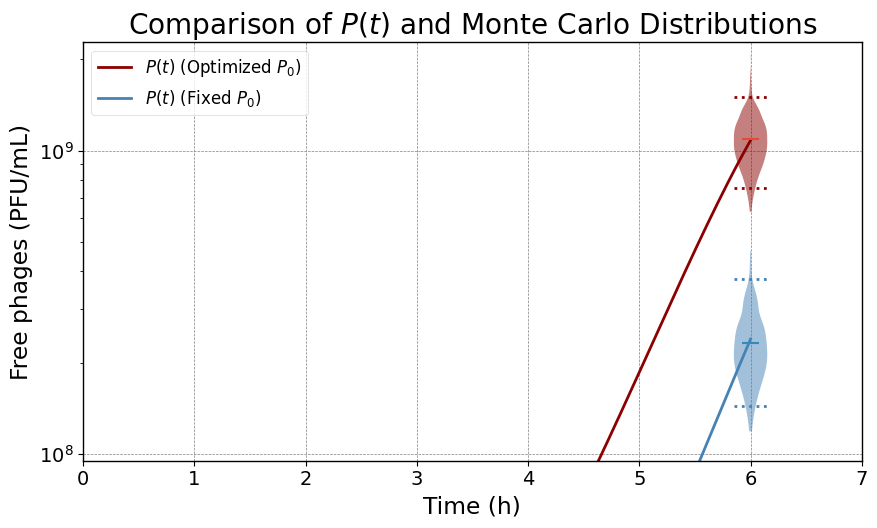

In [ ]:
# IC de ambas simulaciones
p2p5_1, p97_1 = np.percentile(results_1, [2.5, 97.5])
p2p5_2, p97_2 = np.percentile(results_2, [2.5, 97.5])

fig, ax = plt.subplots(figsize=(9, 5.5))

# --- Curvas simuladas ---
ax.plot(t_vals_1, P_vals_1, color='darkred', label='$P(t)$ (Optimized $P_0$)', linewidth=2)
ax.plot(t_vals_2, P_vals_2, color='steelblue', label='$P(t)$ (Fixed $P_0$)', linewidth=2)

# --- Gráfico de violín 1 ---
vp1 = ax.violinplot(results_1, positions=[6], widths=0.3,
                    showmeans=False, showmedians=True, showextrema=False)
for body in vp1['bodies']:
    body.set_facecolor('darkred')
    body.set_alpha(0.5)

# --- Gráfico de violín 2 ---
vp2 = ax.violinplot(results_2, positions=[6], widths=0.3,
                    showmeans=False, showmedians=True, showextrema=False)
for body in vp2['bodies']:
    body.set_facecolor('steelblue')
    body.set_alpha(0.5)

# --- Líneas IC del 95% ---
ax.hlines([p2p5_1, p97_1], xmin=5.85, xmax=6.15, colors='darkred', linestyles='dotted', linewidth=2)
ax.hlines([p2p5_2, p97_2], xmin=5.85, xmax=6.15, colors='steelblue', linestyles='dotted', linewidth=2)

# --- Formato del gráfico ---
ax.set_xlim(0, 7)
ax.set_ylim(min(min(results_1), min(results_2)) * 0.8,
            max(max(results_1), max(results_2)) * 1.1)
ax.set_yscale('log')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Free phages (PFU/mL)')
ax.set_title('Comparison of $P(t)$ and Monte Carlo Distributions')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

# Monte-Carlo con Optimización

In [ ]:
# ----------------------------- MONTE CARLO -----------------------------
results = []
opt_values = []
N_ITER = 300  # número de iteraciones

for i in range(N_ITER):
    sampled_p = generar_parametros_aleatorios()
    obj_fn = make_objective(sampled_p)
    bounds = FloatVar(lb=[3, 0.1], ub=[7, 6.0])
    problem = {"obj_func": obj_fn, "bounds": bounds, "minmax": "min"}
    model = GWO.OriginalGWO(epoch=30, pop_size=20, verbose=False)
    best = model.solve(problem)
    log_inj, t_inf = best.solution
    P_max = -best.target.fitness
    results.append(P_max)
    opt_values.append((log_inj, t_inf))

# ----------------------------- RESULTADOS -----------------------------

df = pd.DataFrame({"P_max": results})

Se han truncado las últimas 5000 líneas del flujo de salida.
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 22, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runtime: 1.58159 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 23, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runtime: 2.01219 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 24, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runtime: 1.18033 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 25, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runtime: 1.21587 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 26, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runtime: 1.20119 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 27, Current best: -1222340189.9238243, Global best: -1222340189.9238243, Runt

In [ ]:
# Crear DataFrame
df_results = pd.DataFrame(opt_values, columns=["log10(P0)", "t_inf"])
df_results["P_max"] = results

# Guardar a CSV
df_results.to_csv("resultados_montecarlo.csv", index=False)

🔹 log10(P0) promedio = 7.000
🔹 P0 promedio = 1.00e+07 PFU
🔹 t_inf promedio = 1.52 h


,log10(P0),t_inf,P_max
count,300.0,300.000000,3.000000e+02
mean,7.0,1.519902,1.086731e+09
std,0.0,0.033360,2.042309e+08
min,7.0,1.444224,6.178308e+08
25%,7.0,1.496761,9.527442e+08
50%,7.0,1.513053,1.084683e+09
75%,7.0,1.539226,1.226961e+09
max,7.0,1.625167,1.668187e+09


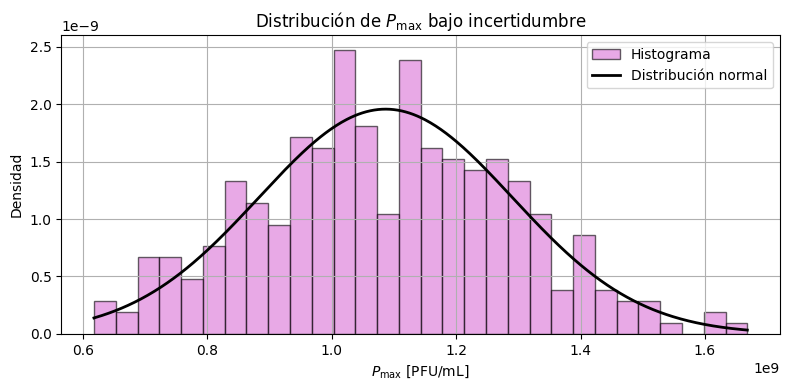

In [ ]:
# Leer archivo
df = pd.read_csv("resultados_montecarlo2.csv")

# Extraer columnas
log10P0 = df["log10(P0)"].values
t_inf = df["t_inf"].values
P_max = df["P_max"].values

# Cálculo estadístico
log_inj_avg = np.mean(log10P0)
t_inf_avg = np.mean(t_inf)
P0_avg = 10**log_inj_avg

print(f"🔹 log10(P0) promedio = {log_inj_avg:.3f}")
print(f"🔹 P0 promedio = {P0_avg:.2e} PFU")
print(f"🔹 t_inf promedio = {t_inf_avg:.2f} h")

# Mostrar tabla
display(df.describe())

# --- Calcular media y desviación estándar ---
mu = np.mean(P_max)
sigma = np.std(P_max)

# --- Histograma con curva normal ---
plt.figure(figsize=(8, 4))
count, bins, _ = plt.hist(P_max, bins=30, density=True,
                          color='orchid', edgecolor='black', alpha=0.6, label="Histograma")

from scipy.stats import norm
# Curva de densidad normal
x_vals = np.linspace(min(P_max), max(P_max), 500)
pdf_vals = norm.pdf(x_vals, mu, sigma)
plt.plot(x_vals, pdf_vals, color='black', linewidth=2, label="Distribución normal")

# Formato
plt.title("Distribución de $P_{\\mathrm{max}}$ bajo incertidumbre")
plt.xlabel("$P_{\\mathrm{max}}$ [PFU/mL]")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

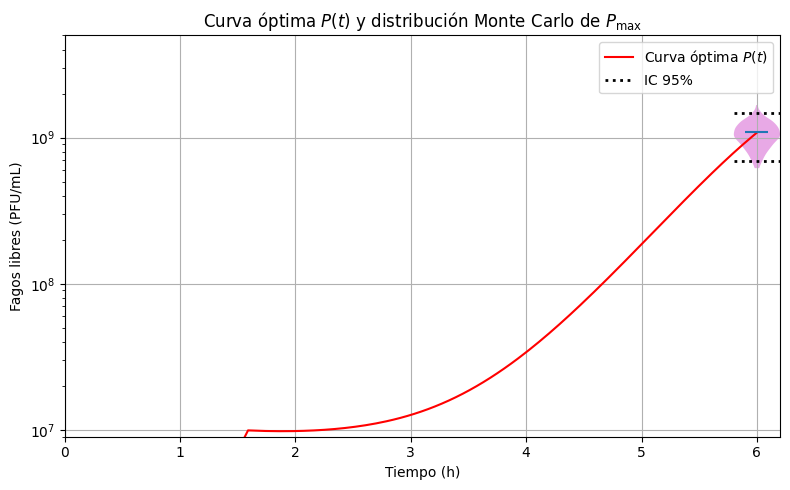

In [ ]:
# --- Modelo ---
delta_t = 0.05
k = 200
P0_rate = 1e7 / delta_t

# Parámetros fijos
a       = 4.99642e-06
s       = 2.47758
rr      = 0.582064
p_decay = 0.0996885

p_opt = [1.69544031e+00, 1.14375220e+08, 1.87165643e-09, 2.15271746e+01]

# Combinar parámetros optimizados y fijos
fixed_params = np.array([p_opt[0], p_opt[1], a, p_opt[2], s, rr, p_opt[3], p_decay])

def modelo_optimo(P0_rate, t_inf):
    x = MX.sym('x', 5)
    t = x[4]
    rn, K, a, ki, s, rr, b, p_decay = fixed_params

    pulse = P0_rate * (1 / (1 + exp(-k * (t - t_inf))) - 1 / (1 + exp(-k * (t - (t_inf + delta_t)))))
    X, XI, XR, P = x[0], x[1], x[2], x[3]
    dX  = rn * X * (1 - (X + XR)/K) - a * X - ki * X * P
    dXI = ki * X * P - s * XI
    dXR = rr * XR * (1 - (X + XR)/K) + a * X
    dP  = b * s * XI - p_decay * P - ki * X * P + pulse
    dt  = 1.0
    dxdt = vertcat(dX, dXI, dXR, dP, dt)
    return integrator('sim', 'cvodes', {'x': x, 'ode': dxdt}, {'tf': 0.03})

# --- Simulación ---
sim = modelo_optimo(P0_rate, 1.513053)
x0 = [2.58e5, 0, 0, 0, 0]
sol = [x0]
for _ in range(200):
    res = sim(x0=sol[-1])
    sol.append(res["xf"].full().flatten())
sol = np.array(sol)
t_vals = sol[:, 4]
P_vals = sol[:, 3]


p2p5 = np.percentile(P_max, 2.5)
p97 = np.percentile(P_max, 97.5)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(8, 5))

# Curva óptima
ax.plot(t_vals, P_vals, color='red', label='Curva óptima $P(t)$')

# Violín
vp = ax.violinplot(P_max, positions=[6], widths=0.4,
                   showmeans=False, showmedians=True, showextrema=False)
for body in vp['bodies']:
    body.set_facecolor('orchid')
    body.set_alpha(0.6)

# Líneas IC del 95%
ax.hlines([p2p5, p97], xmin=5.8, xmax=6.2, colors='black', linestyles='dotted', linewidth=2, label='IC 95%')

# Formato
ax.set_xlim(0, 6.2)
ax.set_ylim(9e6, 5e9)
ax.set_yscale('log')
ax.set_xlabel('Tiempo (h)')
ax.set_ylabel('Fagos libres (PFU/mL)')
ax.set_title('Curva óptima $P(t)$ y distribución Monte Carlo de $P_{\\mathrm{max}}$')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

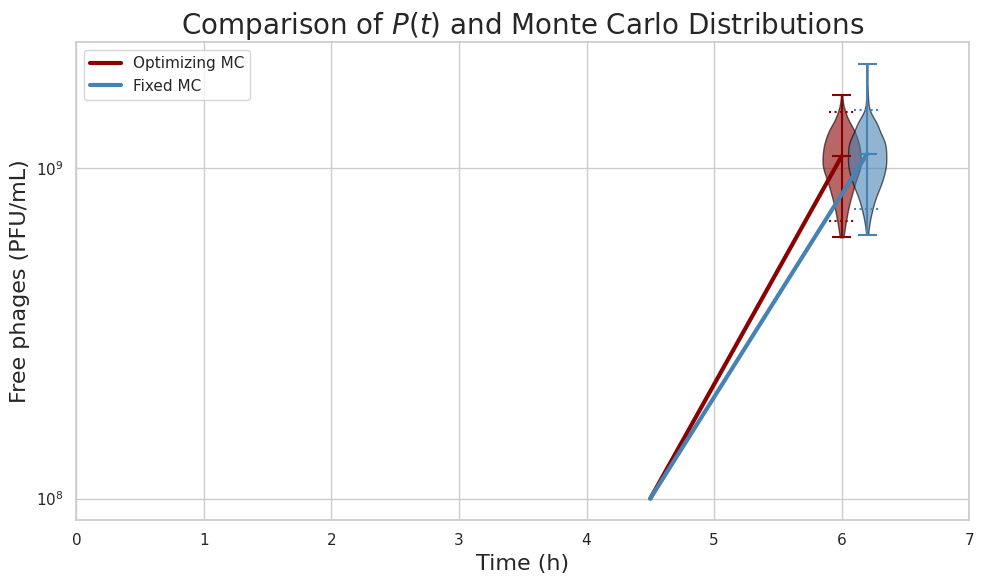

In [ ]:
# === Cargar datos ===
df_fijo = pd.read_excel("montecarlo_fijo.xlsx")
df_opt = pd.read_csv("resultados_montecarlo2.csv")

# === Crear gráfico ===
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# === Violin plots ===
parts1 = plt.violinplot(df_opt["P_max"], positions=[6], widths=0.3, showmeans=True)
parts2 = plt.violinplot(df_fijo["P_max"], positions=[6.2], widths=0.3, showmeans=True)

# === Personalizar colores ===
for pc in parts1['bodies']:
    pc.set_facecolor('darkred')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)
for pc in parts2['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
    parts1[partname].set_color('darkred')
    parts2[partname].set_color('steelblue')

# === Líneas de crecimiento (simulaciones) ===
plt.plot([4.5, 6], [1e8, df_opt["P_max"].mean()], color='darkred', linewidth=3, label=r"Optimizing MC")
plt.plot([4.5, 6.2], [1e8, df_fijo["P_max"].mean()], color='steelblue', linewidth=3, label=r"Fixed MC")

# === Intervalos de confianza del 95% ===
# Optimizado
opt_q1, opt_q3 = np.percentile(df_opt["P_max"], [2.5, 97.5])
plt.hlines([opt_q1, opt_q3], xmin=5.9, xmax=6.1, colors='darkred', linestyles='dotted')
# Fijo
fijo_q1, fijo_q3 = np.percentile(df_fijo["P_max"], [2.5, 97.5])
plt.hlines([fijo_q1, fijo_q3], xmin=6.1, xmax=6.3, colors='steelblue', linestyles='dotted')

# === Ajustes finales ===
plt.yscale("log")
plt.xticks(np.arange(0, 8, 1))
plt.xlim(0, 7)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("Free phages (PFU/mL)", fontsize=16)
plt.title("Comparison of $P(t)$ and Monte Carlo Distributions", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()